In [1]:
df_nobdf_nobfrom HeaderP import *

# Train RF used to vet periods

In [2]:
import Astraea
def RFregressor(df,testF,modelout=False,traind=0.8,ID_on='KID',X_train_ind=[],X_test_ind=[],target_var='Prot',target_var_err='Prot_err',chisq_out=False,MREout=False,n_estimators=100,
criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False):
    """Train RF regression model and perform cross-validation test. 
    
    It uses scikit-learn Random Forest regressor model. All default hyper-parameters are taken from the scikit-learn model that user can change by adding in optional inputs. More details on hyper-parameters, see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html. To use the module to train a RF model to predict rotation period, input a pandas dataFrame with column names as well as a list of attribute names. 
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains all variables needed
      testF ([string list]): List of feature names used to train
      modelout (Optional [bool]): Whether to only output the trained model 
      traind (Optinal [float]): Fraction of data use to train, the rest will be used to perform cross-validation test (default 0.8)
      ID_on (Optional [string]): What is the star identifier column name (default 'KID'). If specified ID column does not exist, it will just take the index as ID
      X_train_ind (Optional [list]): List of *ID_on* for training set, if not specified, take random *traind* fraction of indexes from *ID_on* column
      X_test_ind (Optional [list]): List of *ID_on* for testing set, if not specified, take the remaining (1-*traind*) fraction of indexes from *ID_on* column that is not in the training set (*X_train_ind*)
      target_var (Optional [string]): Label column name (default 'Prot')
      target_var_err (Optional [string]): Label error column name (default 'Prot_err')
      chisq_out (optional [bool]): If true, only output average chisq value
      MREout (optional [bool]): If true, only output median relative error. If both *chisq_out* and *MREout* are true, then output only these two values
      
    Returns: 
      <RF model>, <pandas.Series>:
      
      :regr: Sklearn RF regressor model (attributes see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
      
      :<pandas.Series> containing:
       
        :actrualF ([string list]): Actrual features used
	:importance ([float list]): Impurity-based feature importance ordering as *actrualF*
	:ID_train ([list]): List of *ID_on* used for training set 
	:ID_test ([list]): List of *ID_on* used for testing set
	:predictp ([float list]): List of prediction on testing set
	:ave_chi ([float]): Average chisq on cross-validation (testing) set
	:MRE_val ([float]): Median relative error on cross-validation (testing) set
	:X_test ([matrix]): Matrix used to predict label values for testing set
	:y_test ([array-like]): Array of true label values of testing set
	:X_train ([matrix]): Matrix used to predict label values for training set
	:y_train ([array-like]): Array of true label values of training set
      
      
    """
   
    print('Simpliest example:\n regr,regr_outs = RFregressor(df,testF)\n')

    if len(X_train_ind)==0:
        print('Fraction of data used to train:',traind)
    else:
        print('Training KID specified!\n')
        print('Estimated fraction of data used to train:',float(len(X_train_ind))/float(len(df[target_var])))
    print('# of Features attempt to train:',len(testF))
    print('Features attempt to train:',testF)

    # check if there is an ID
    if ID_on not in df.columns:
        df[ID_on]=range(len(df))
        print('ID column not found, using index as ID!')

    fl=len(df.columns) # how many features
    keys=range(fl)
    flib=dict(zip(keys, df.columns))
    
    featl_o=len(df[target_var]) # old feature length before dropping
    
    actrualF=[] # actrual feature used
    # fill in feature array
    lenX=0
    missingf=[]
    for i in df.columns:
        feature=df[i].values
        if (type(feature[0]) is not str) and (i in testF):
            if sum(np.isnan(feature))<0.1*featl_o:
                lenX=lenX+1
                actrualF.append(i)
            else:
                missingf.append(i)
            
    X=df[actrualF]
    X=X.replace([np.inf, -np.inf], np.nan)
    X=X.dropna()

    featl=np.shape(X)[0]
    #print(featl)
    print(str(featl_o)+' stars in dataframe!')
    if len(missingf)!=0:
        print('Missing features:',missingf)
    if (featl_o-featl)!=0:
        print('Missing '+ str(featl_o-featl)+' stars from null values in data!\n')

    print(str(featl)+' total stars used for RF!')
    

    #print(X_train_ind)

    if len(X_train_ind)==0:
        # output
        y=df[target_var][X.index].values
        y_err=df[target_var_err][X.index].values
        ID_ar=df[ID_on][X.index].values
        X=X.values
	
        Ntrain = int(traind*featl)
        # Choose stars at random and split.
        shuffle_inds = np.arange(len(y))
        np.random.shuffle(shuffle_inds)
        train_inds = shuffle_inds[:Ntrain]
        test_inds = shuffle_inds[Ntrain:]
	
        y_train, y_train_err, ID_train, X_train = y[train_inds], y_err[train_inds],ID_ar[train_inds],X[train_inds, :]
        y_test, y_test_err, ID_test, X_test = y[test_inds], y_err[test_inds],ID_ar[test_inds],X[test_inds, :]
	
        test_inds,y_test, y_test_err, ID_test, X_test=zip(*sorted(zip(test_inds,y_test, y_test_err, ID_test, X_test)))
        test_inds=np.array(test_inds)
        y_test=np.array(y_test)
        y_test_err=np.array(y_test_err)
        ID_test=np.array(ID_test)
        X_test=np.asarray(X_test)
	
    else:
        datafT=df.loc[X.index].loc[df[ID_on].isin(X_train_ind)]
        datafTes=df.loc[X.index].loc[df[ID_on].isin(X_test_ind)]
        y_train, y_train_err,X_train = datafT[target_var].values, datafT[target_var_err].values,X.loc[df[ID_on].isin(X_train_ind)].values
        y_test, y_test_err,X_test = datafTes[target_var].values, datafTes[target_var].values,X.loc[df[ID_on].isin(X_test_ind)].values
    print(str(len(y_train))+' training stars!')



    # run random forest
    regr = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, verbose=verbose, warm_start=warm_start)
    regr.fit(X_train, y_train)  
    
    

    # get the importance of each feature
    importance=regr.feature_importances_
    
    print('Finished training! Making predictions!')
    # make prediction
    predictp=regr.predict(X_test)
    print('Finished predicting! Calculating statistics!')
     
    # calculate chisq and MRE
    MRE_val=MRE(y_test,predictp,y_test_err)
    ave_chi=calcChi(y_test,predictp,y_test_err)

    print('Median Relative Error is:',MRE_val)
    print('Average chi^2 is:',ave_chi)
    
    if chisq_out:
        if MREout:
            print('Finished!')
            return ave_chi,MRE_val
        else:
            print('Finished!')
            return ave_chi
    elif MREout:
        print('Finished!')
        return MRE_val
    else:
        if len(X_train_ind)!=0:
            ID_train=datafT[ID_on].values
            ID_test=datafTes[ID_on].values
            ID_train=[int(i) for i in ID_train]
            ID_test=[int(i) for i in ID_test]
        print('Finished!')
        return regr,pd.Series([importance,actrualF,ID_train,ID_test,predictp,ave_chi,MRE_val,X_test,y_test,X_train,y_train],index=['importance','actrualF','ID_train','ID_test','prediction','ave_chi2','MRE','X_test','y_test','X_train','y_train'])
    
    
def plot_result(actrualF,importance,prediction,y_test,y_test_err=[],topn=20,MS=3,labelName='Period'):
    """Plot impurity-based feature importance as well as predicted values vs true values for a random forest model
    
    Args:
      actrualF ([array-like]): Feature used (from function output of RFregressor())
      importance ([array-like]): importance of the model (from function output of RFregressor())
      prediction ([array-like]): Predicted values (from function output of RFregressor())
      y_test ([array-like]): true values (from function output of RFregressor())
      y_test_err (Optional [array-like]): Errors for true values (from function output of RFregressor())
      topn (Optional [int]): How many most important features to plot
      MS (Optional [int]): Markersize for plotting true vs predicted values
      labelName (Optional [string]): Label name
    
    Returns:
      <matplotlib.plot>: importance plot as well as true vs prediction plot
    """
    
    plt.rcParams.keys()
    plt.rc('font', family='serif')
    params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
    }
    plt.rcParams.update(params)

    topn=min([topn,len(actrualF)])
    # zip the importance with its feature name
    list1 = list(zip(actrualF,importance))
    # sort the zipped list
    decend=sorted(list1, key=lambda x:x[1],reverse=True)
    #print(decend)

    # how many features to plot 
    x=range(topn)
    
    ####################  get most important features ############################################################
    y_val=[decend[i][1] for i in range(topn)]
    my_xticks=[decend[i][0] for i in range(topn)]

    plt.figure(figsize=(20,5))
    plt.title('Most important features',fontsize=25)
    plt.xticks(x, my_xticks)
    plt.plot(x, y_val,'k-')
    plt.xlim([min(x),max(x)])
    plt.xticks(rotation=90)
    plt.ylabel('importance')
    ####################  get most important features ############################################################

    # prediction vs true
    if len(y_test_err)==0:
        plt.figure(figsize=(10,8))
        plt.plot(sorted(prediction),sorted(prediction),'k-',label='y=x')
        plt.plot(sorted(prediction),sorted(1.1*prediction),'b--',label='10% Error')
        plt.plot(sorted(prediction),sorted(0.9*prediction),'b--')
        plt.plot(y_test,prediction,'r.',markersize=MS,alpha=0.2)
        plt.ylabel('Predicted '+labelName)
        plt.xlabel('True '+labelName)
        plt.ylim([min(prediction),max(prediction)])
        plt.xlim([min(prediction),max(prediction)])
        plt.legend()
    else:
        plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(sorted(prediction),sorted(prediction),'k-',label='y=x')
        plt.plot(sorted(prediction),sorted(1.1*prediction),'b--',label='10% Error')
        plt.plot(sorted(prediction),sorted(0.9*prediction),'b--')
        plt.plot(y_test,prediction,'r.',markersize=MS,alpha=0.2)
        plt.ylabel('Predicted '+labelName)
        plt.xlabel('True Period')
        plt.ylim([min(prediction),max(prediction)])
        plt.xlim([min(prediction),max(prediction)])
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(sorted(prediction),sorted(prediction),'k-',label='y=x')
        plt.plot(sorted(prediction),sorted(1.1*prediction),'b--',label='10% Error')
        plt.plot(sorted(prediction),sorted(0.9*prediction),'b--')
        plt.errorbar(y_test,prediction,xerr=y_test_err,fmt='r.',markersize=MS,alpha=0.2)
        plt.ylabel('Predicted '+labelName)
        plt.xlabel('True '+labelName)
        plt.ylim([min(prediction),max(prediction)])
        plt.xlim([min(prediction),max(prediction)])
        plt.legend()
    
        avstedv=MRE(y_test,prediction,y_test_err)
        print('Median relative error is: ',avstedv)


In [3]:
df = pd.read_csv('../StarAgeComp/allgyro_ztf_kepler_update.csv')
data = fits.open('../NewGyroKineage/dr3-rv-good-plx-MilkyWayPotential2022-joined.fits')
kinematic = data[1].data

df['Prot_err'] = 0.1*df['Prot']
#test = pd.read_csv('spinspotter_by_star.zip')

In [4]:
ids = pd.DataFrame(kinematic.source_id, 
                  columns=['source_id'])
checklist = ids['source_id'].isin(df.source_id)


In [5]:
kinematic_dr3 = kinematic[checklist]
kinematic_dr3['source_id']

array([     44362718023680,      77863462880768,     143593642261120, ...,
       4611092114646942336, 4611265974923449984, 4611297581585824256])

In [6]:

kinematic_dr3 = pd.DataFrame(np.array((kinematic_dr3.source_id,
                                      kinematic_dr3.xyz[:,0],
                                      kinematic_dr3.xyz[:,1],
                                      kinematic_dr3.xyz[:,2],
                                      kinematic_dr3.vxyz[:,0],
                                      kinematic_dr3.vxyz[:,1],
                                      kinematic_dr3.vxyz[:,2],
                                      kinematic_dr3.actions[:,0],
                                      kinematic_dr3.actions[:,1],
                                       kinematic_dr3.actions[:,2],
                                      kinematic_dr3.E,
                                      kinematic_dr3.L[:,0],
                                      kinematic_dr3.L[:,1],
                                      kinematic_dr3.L[:,2],
                                      kinematic_dr3.ecc,
                                      kinematic_dr3.parallax),dtype=str).T,
                            columns=['source_id','x','y','z',
                                    'vx','vy','vz','Jx','Jy',
                                    'Jz','E','Lx','Ly','Lz','e',
                                     'parallax'])




In [7]:
for i in kinematic_dr3.columns:
    if i=='source_id':
        kinematic_dr3[i] = [int(j) for j in kinematic_dr3[i]]
        continue
    kinematic_dr3[i] = [float(j) for j in kinematic_dr3[i]]

In [8]:
df = pd.merge(df, kinematic_dr3,
             left_on='source_id',right_on='source_id',
             how='left')
len(df)


243862

In [9]:
df

source_id     bp_rp      abs_G         teff    gyroAge  \
0       2050233601176543104  1.059423   5.313724  5114.412109   0.003271   
1       2050231848829944320  1.154961   5.611682  4894.051270   2.238229   
2       2050246795316078336  0.970336   3.678753  5342.067383   0.288323   
3       2050234735047928320  1.047448   5.355787  5143.771484   2.735725   
4       2050232256840088960  0.874867   1.841302  5609.369629   0.374227   
...                     ...       ...        ...          ...        ...   
243857  1389471643094026752  3.247257  12.340819  3044.645671   7.193423   
243858  1389487551652929536  2.603479  10.319411  3392.871705  11.475791   
243859  1389491399943635456  2.874805  10.250312  3232.361159   0.258614   
243860  4016611500633974528  2.127324   8.863735  3711.829067   1.036700   
243861  3352078939236926592  1.819355   7.417681  3947.162339   0.726568   

             KIC        Prot   Prot_err         x         y  ...         vz  \
0       757099.0    0.360000   0.036000 -7.996666  0.329122  ...  -5.764138   
1       757450.0   19.120000   1.912000       NaN       NaN  ...        NaN   
2       891916.0    5.450000   0.545000       NaN       NaN  ...        NaN   
3       892195.0   21.780000   2.178000 -7.961510  0.422290  ...  -1.234259   
4       892713.0    5.780000   0.578000 -7.749626  0.981157  ... -13.110220   
...          ...         ...        ...       ...       ...  ...        ...   
243857       NaN  107.106698  10.710670       NaN       NaN  ...        NaN   
243858       NaN  118.302650  11.830265       NaN       NaN  ...        NaN   
243859       NaN   12.529327   1.252933       NaN       NaN  ...        NaN   
243860       NaN   18.960201   1.896020 -8.156997  0.006348  ...   3.132266   
243861       NaN   13.458430   1.345843 -8.414054 -0.111292  ...  13.333245   

               Jx           Jy        Jz              E        Lx         Ly  \
0       14.628886 -1642.988798  0.482320 -134978.046918  1.414685  -0.738174   
1             NaN          NaN       NaN            NaN       NaN        NaN   
2             NaN          NaN       NaN            NaN       NaN        NaN   
3        1.971911 -1835.391331  0.417230 -129718.554701  0.863847  -0.385568   
4        9.139710 -1820.128561  2.638049 -129699.607185  7.439537 -10.924559   
...           ...          ...       ...            ...       ...        ...   
243857        NaN          NaN       NaN            NaN       NaN        NaN   
243858        NaN          NaN       NaN            NaN       NaN        NaN   
243859        NaN          NaN       NaN            NaN       NaN        NaN   
243860   0.118404 -1878.021346  1.907194 -128471.687433  1.231237 -20.687729   
243861  19.087957 -1895.809148  1.271623 -127307.196913 -3.917704  -3.737575   

                 Lz         e  parallax  
0      -1642.988798  0.111673  2.798592  
1               NaN       NaN       NaN  
2               NaN       NaN       NaN  
3      -1835.391331  0.039326  2.181444  
4      -1820.128561  0.084711  0.939310  
...             ...       ...       ...  
243857          NaN       NaN       NaN  
243858          NaN       NaN       NaN  
243859          NaN       NaN       NaN  
243860 -1878.021346  0.009529  4.898665  
243861 -1895.809148  0.119992  3.192147  

[243862 rows x 23 columns]

In [10]:
#df.to_csv('all_gyro_kin.csv', index=False)
listtrain = ['Jz','bp_rp','abs_G','vx','vy','vz',
                'Jx','Jy','Lx','Ly','Lz','e']
df = df.dropna(subset=['Prot'])
df = df.dropna(subset=listtrain)


In [11]:
df_kepler = df.dropna(subset=['KIC']).reset_index(drop=True)
df_ztf = df.loc[~(df.index.isin(df_kepler.index))]
#df_ztf = df_ztf.loc[df_ztf['Prot']>20].reset_index(drop=True)
len(df_kepler), len(df_ztf), len(df)

(29376, 42279, 59682)

In [12]:

regr_kepler, regr_outs_kepler = RFregressor(df_kepler, listtrain,
                                      target_var='Prot', target_var_err='Prot_err', 
                                      n_estimators=100)

regr_ztf, regr_outs_ztf = RFregressor(df_ztf, listtrain,
                                      target_var='Prot', target_var_err='Prot_err', 
                                      n_estimators=100)

regr, regr_outs = RFregressor(df, listtrain,
                                      target_var='Prot', target_var_err='Prot_err', 
                                      n_estimators=100)

Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 12
Features attempt to train: ['Jz', 'bp_rp', 'abs_G', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Lx', 'Ly', 'Lz', 'e']
ID column not found, using index as ID!
29376 stars in dataframe!
29376 total stars used for RF!
23500 training stars!


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.32704352536092707
Average chi^2 is: 182.95912975492817
Finished!
Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 12
Features attempt to train: ['Jz', 'bp_rp', 'abs_G', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Lx', 'Ly', 'Lz', 'e']
ID column not found, using index as ID!


/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_34545/237977728.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ID_on]=range(len(df))


42279 stars in dataframe!
42279 total stars used for RF!
33823 training stars!


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.2748229633875431
Average chi^2 is: 149.5650300556146
Finished!
Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 12
Features attempt to train: ['Jz', 'bp_rp', 'abs_G', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Lx', 'Ly', 'Lz', 'e']
ID column not found, using index as ID!
59682 stars in dataframe!
59682 total stars used for RF!
47745 training stars!


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.28918809821057034
Average chi^2 is: 133.25598868567124
Finished!


Text(0, 0.5, 'Predicted Period [Days]')

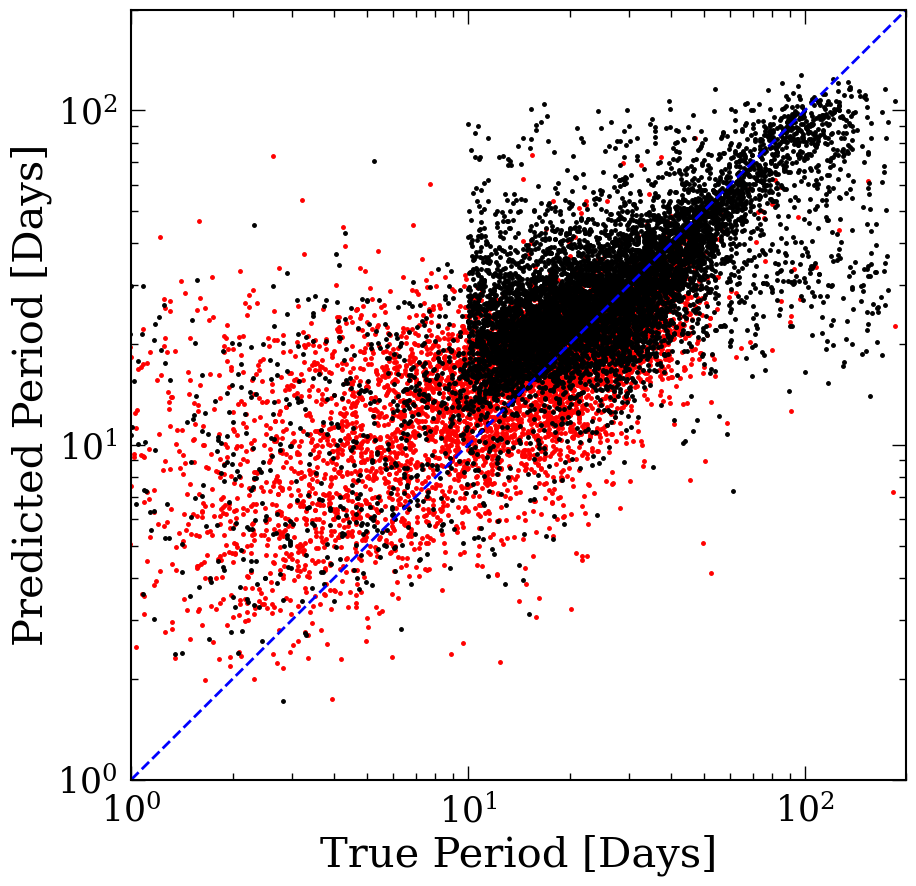

In [13]:
plt.plot(regr_outs_kepler['y_test'], regr_outs_kepler['prediction'], 'r.',
        label='Kepler', markersize=5)
plt.plot(regr_outs_ztf['y_test'], regr_outs_ztf['prediction'], 'k.',
        label='ZTF', markersize=5)


"""plt.hexbin(regr_outs_ztf['y_test'], regr_outs_ztf['prediction'],
          extent=(np.log10(1),np.log10(200), np.log10(1),np.log10(200)),
          xscale='log', yscale='log', cmap=plt.get_cmap('plasma',10),
          mincnt=1)"""
"""plt.hexbin(regr_outs_kepler['y_test'], regr_outs_kepler['prediction'],
          extent=(np.log10(1),np.log10(200), np.log10(1),np.log10(200)),
          xscale='log', yscale='log', cmap=plt.get_cmap('plasma',10),
          mincnt=1)"""
"""plt.hexbin(regr_outs['y_test'], regr_outs['prediction'],
          extent=(np.log10(1),np.log10(200), np.log10(1),np.log10(200)),
          xscale='log', yscale='log', cmap=plt.get_cmap('plasma',10),
          mincnt=1)"""

plt.xscale('log')
plt.yscale('log')
plt.xlim([1,200])
plt.ylim([1,200])
plt.plot([1,200], [1,200], 'b--')
plt.xlabel('True Period [Days]')
plt.ylabel('Predicted Period [Days]')

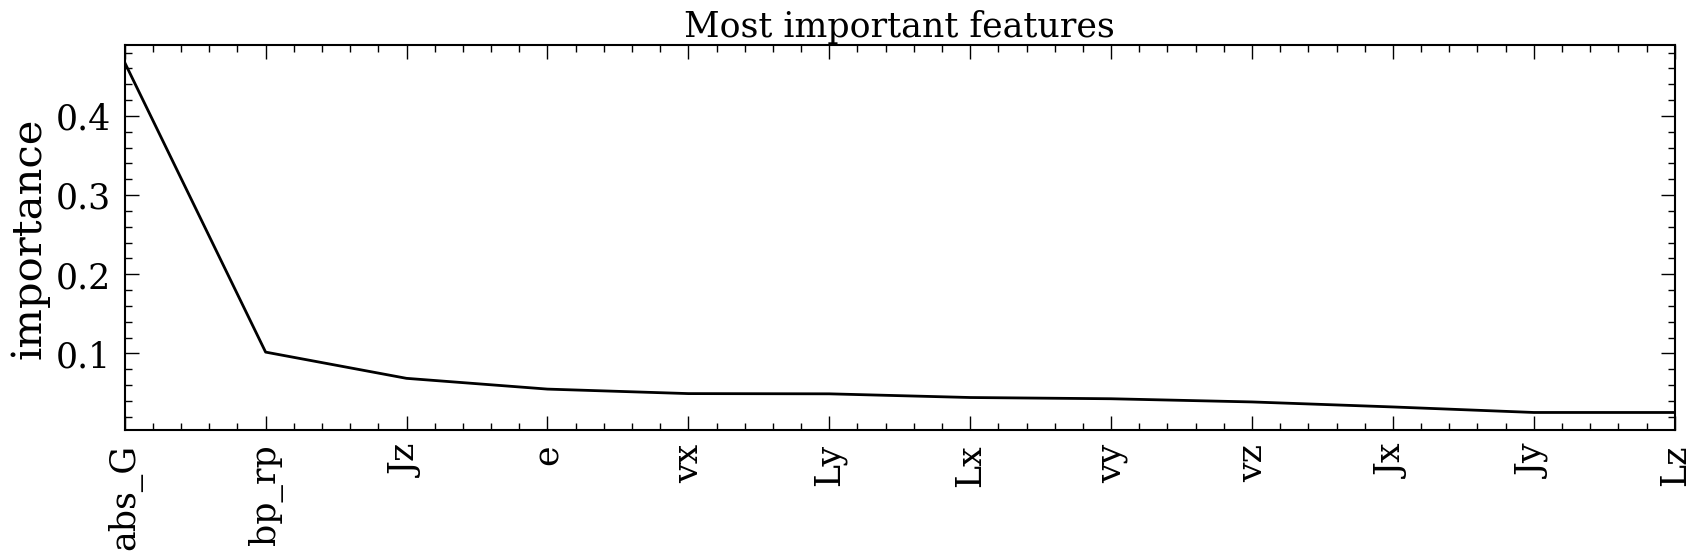

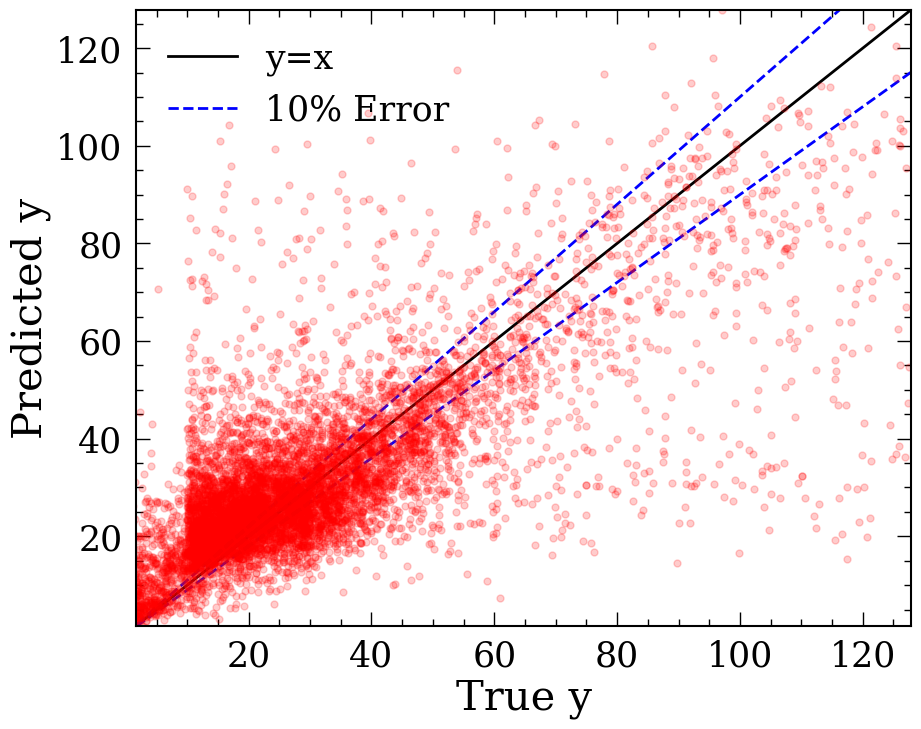

In [14]:
plot_result(regr_outs_ztf['actrualF'], regr_outs_ztf['importance'], 
            regr_outs_ztf['prediction'],
                    regr_outs_ztf['y_test'], labelName='y', MS=10)

In [15]:
df_ztf['Prot_pred'] = regr_kepler.predict(df_ztf[regr_outs_kepler['actrualF']])
df_kepler['Prot_pred'] = regr_ztf.predict(df_kepler[regr_outs_ztf['actrualF']])


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_34545/590899807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ztf['Prot_pred'] = regr_kepler.predict(df_ztf[regr_outs_kepler['actrualF']])
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


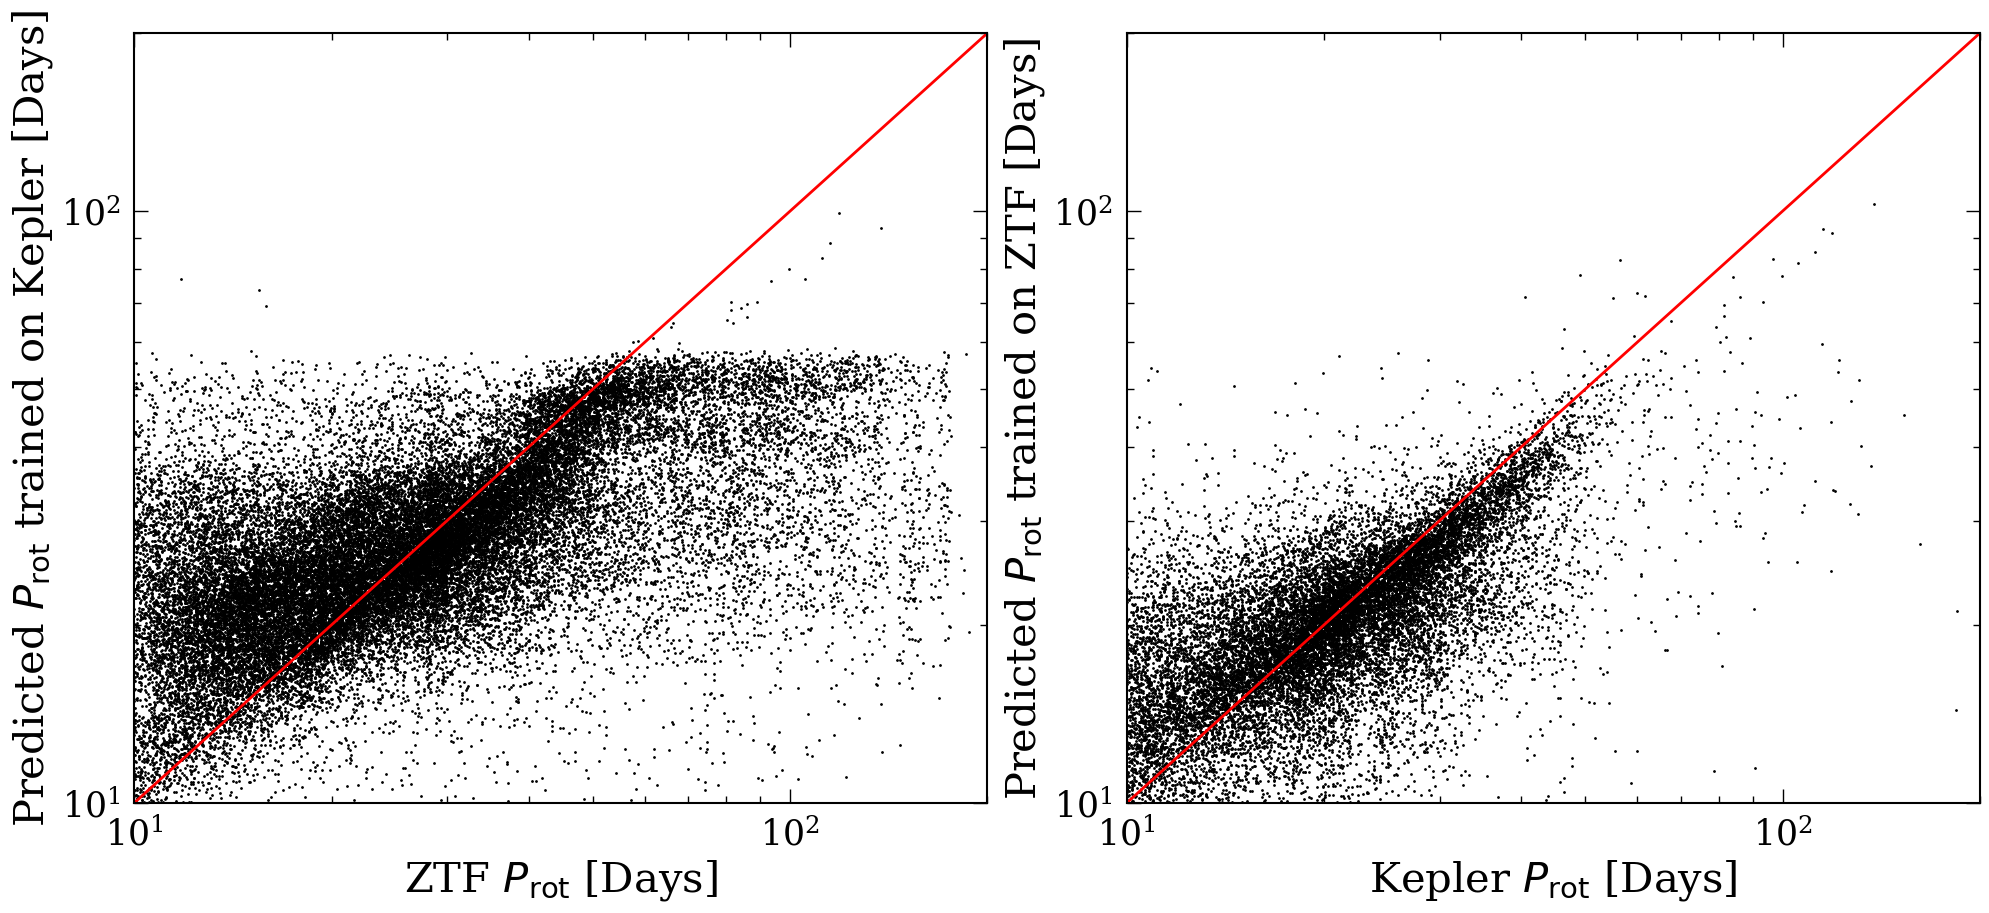

In [96]:
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.plot(df_ztf['Prot'], df_ztf['Prot_pred'], 'k.',markersize=2)
plt.xlim([10,200])
plt.ylim([10,200])
plt.plot([10,200],[10,200],'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ZTF $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ trained on Kepler [Days]')

plt.subplot(1,2,2)
plt.plot(df_kepler['Prot'], df_kepler['Prot_pred'], 'k.',markersize=2)
plt.xlim([10,200])
plt.ylim([10,200])
plt.plot([10,200],[10,200],'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Kepler $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ trained on ZTF [Days]')
plt.tight_layout()

# Predict periods

In [27]:
kinematic_dr3_id = pd.DataFrame(np.array((kinematic.source_id),
                                      dtype=int),columns=['source_id'])


In [31]:
kinematic_dr3 = pd.DataFrame(np.array((kinematic.xyz[:,0],
                                      kinematic.xyz[:,1],
                                      kinematic.xyz[:,2],
                                      kinematic.vxyz[:,0],
                                      kinematic.vxyz[:,1],
                                      kinematic.vxyz[:,2],
                                      kinematic.actions[:,0],
                                      kinematic.actions[:,1],
                                       kinematic.actions[:,2],
                                      kinematic.E,
                                      kinematic.L[:,0],
                                      kinematic.L[:,1],
                                      kinematic.L[:,2],
                                      kinematic.ecc,
                                      kinematic.parallax,
                                      kinematic.bp_rp,
                                      kinematic.phot_g_mean_mag,)).T,
                            columns=['x','y','z','vx','vy','vz','Jx','Jy',
                                    'Jz','E','Lx','Ly','Lz','e',
                                     'parallax','bp_rp','gmag'])

kinematic_dr3 = pd.concat([kinematic_dr3_id, kinematic_dr3], axis=1)

for i in kinematic_dr3.columns:
    if i=='source_id':
        kinematic_dr3[i] = [int(j) for j in kinematic_dr3[i]]
        continue
    kinematic_dr3[i] = [float(j) for j in kinematic_dr3[i]]

In [32]:
kinematic_dr3['abs_G'] = m_to_M(kinematic_dr3['gmag'], 1/kinematic_dr3['parallax'])

In [33]:
kinematic_dr3['source_id']

0                   38655544960
1                 2851858288640
2                 3332894779520
3                 3371550165888
4                 4711579935744
                   ...         
29850341    6917526210142535936
29850342    6917527206576791808
29850343    6917527721971537664
29850344    6917528443525529728
29850345    6917528649684202496
Name: source_id, Length: 29850346, dtype: int64

In [34]:
kinematic_dr3 = kinematic_dr3.dropna(subset=listtrain)
len(kinematic_dr3)

27926397

In [35]:
kinematic_dr3['Prot_pred'] = regr.predict(kinematic_dr3[regr_outs['actrualF']])



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [36]:
#kinematic_dr3.to_csv('kinematic_pred_prot.csv', index=False)
kinematic_dr3 = pd.read_csv('kinematic_pred_prot.csv')

In [37]:
kinematic_dr3 = kinematic_dr3.loc[kinematic_dr3['abs_G']>4.2]
p = fitpoints(kinematic_dr3['bp_rp'], kinematic_dr3['abs_G'], 6)
kinematic_dr3 = kinematic_dr3.loc[kinematic_dr3['abs_G']>p(kinematic_dr3['bp_rp'])-1]
p = fitpoints(kinematic_dr3['bp_rp'], kinematic_dr3['abs_G'], 1)
kinematic_dr3 = kinematic_dr3.loc[kinematic_dr3['abs_G']>p(kinematic_dr3['bp_rp'])-1]
p = fitpoints(kinematic_dr3['bp_rp'], kinematic_dr3['abs_G'], 3)
kinematic_dr3 = kinematic_dr3.loc[kinematic_dr3['abs_G']<p(kinematic_dr3['bp_rp'])+1]



Text(0, 0.5, 'Predicted $P_{\\rm rot}}$ [Days]')

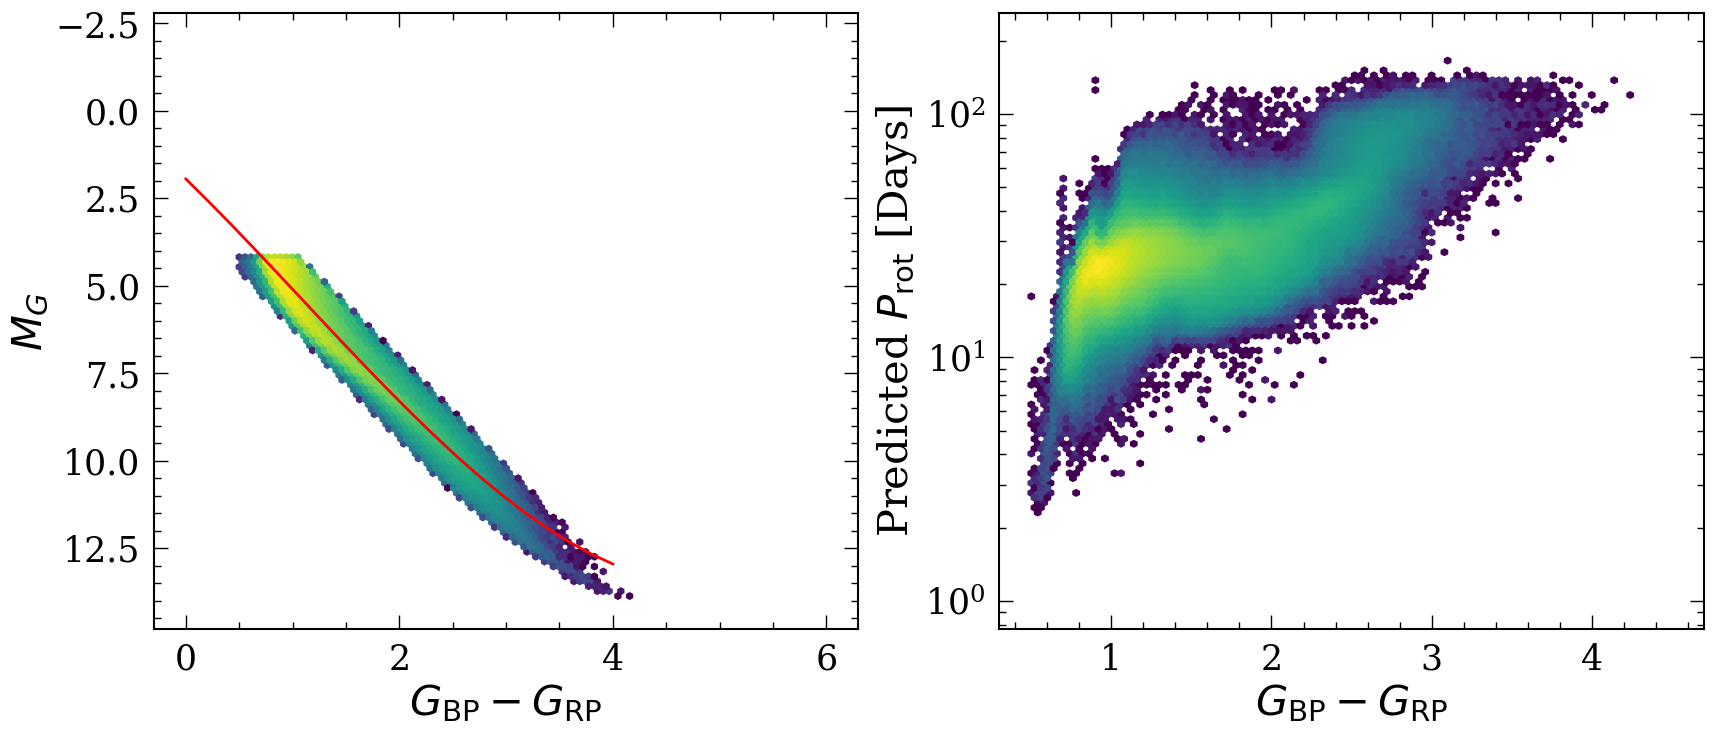

In [38]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(kinematic_dr3['bp_rp'], kinematic_dr3['abs_G'],
          extent=(0.5,6,-2,14), mincnt=1, bins='log')
plt.gca().invert_yaxis()
p = fitpoints(kinematic_dr3['bp_rp'], kinematic_dr3['abs_G'], 3)
plt.plot(np.linspace(0,4,20), p(np.linspace(0,4,20)), 'r-')
plt.xlabel('$G_{\\rm BP}-G_{\\rm RP}$')
plt.ylabel('$M_G$')

plt.subplot(1,2,2)
plt.hexbin(kinematic_dr3['bp_rp'], kinematic_dr3['Prot_pred'],
          extent=(0.5,4.5,0,2.3), mincnt=1, yscale='log', bins='log')
plt.xlabel('$G_{\\rm BP}-G_{\\rm RP}$')
plt.ylabel('Predicted $P_{\\rm rot}}$ [Days]')


In [39]:
#kinematic_dr3.to_csv('kinematic_pred_prot_vet.csv', index=False)

# Use the RF prediction to get periods

In [40]:
ztf_all = pd.read_pickle('/Users/yl4331/Desktop/ZTF/osg/ZTF_gaiaCross/twosame.pkl')


In [42]:
ztf_all = pd.merge(ztf_all, kinematic_dr3, left_on='gaiaid',
                  right_on='source_id', how='inner')


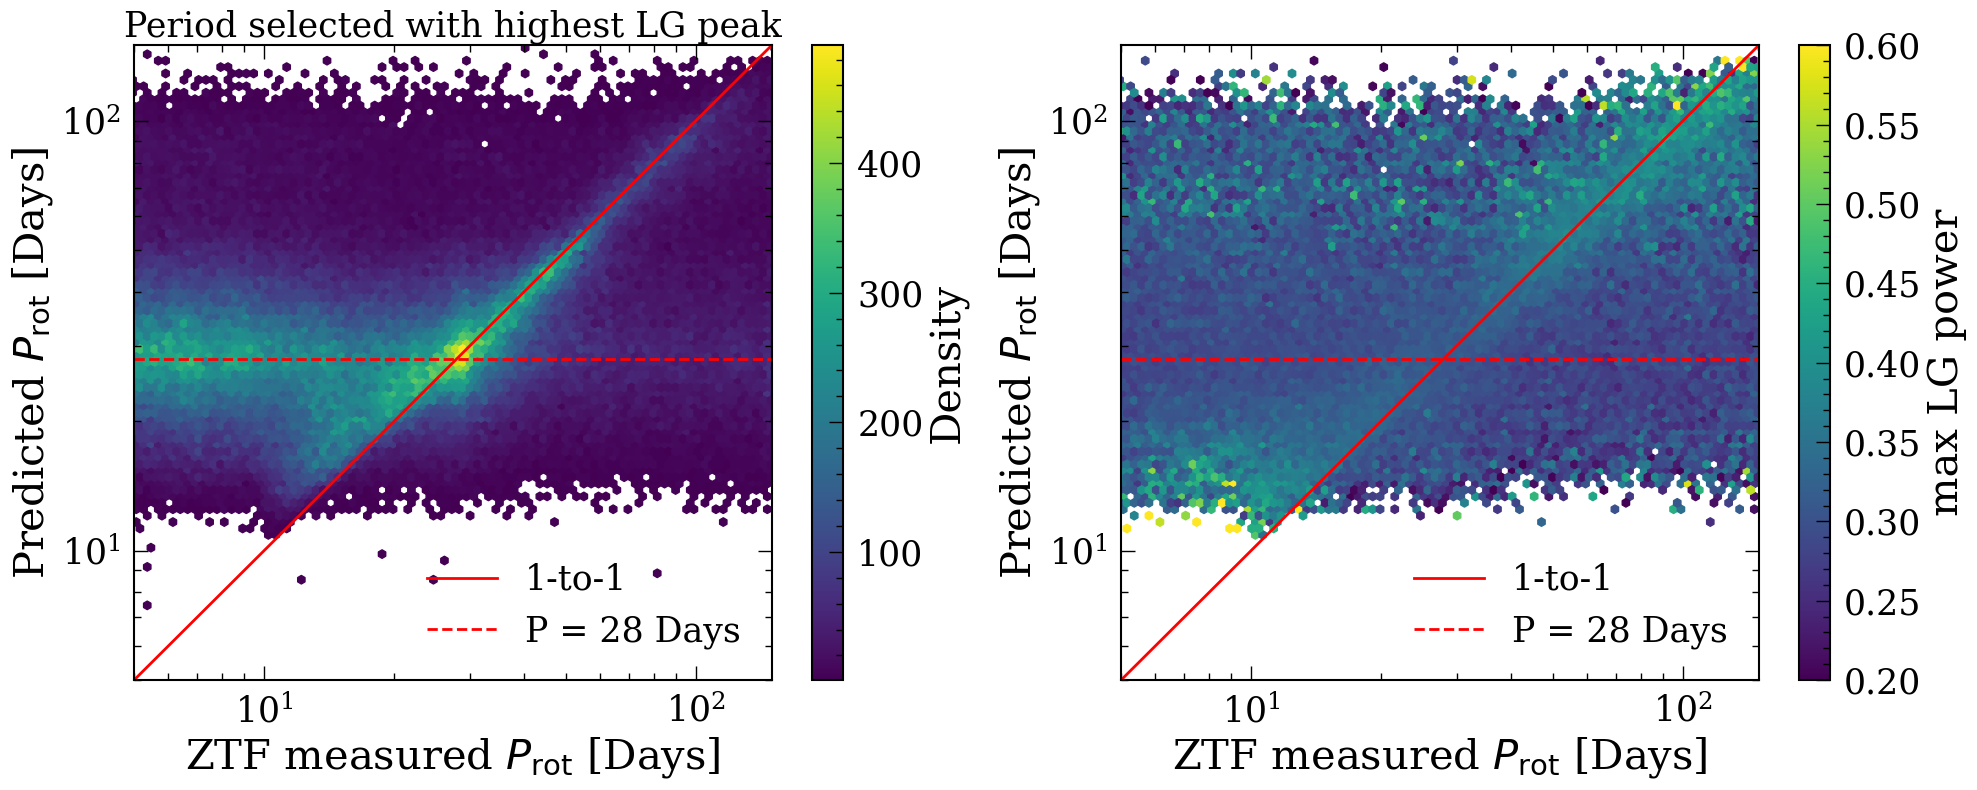

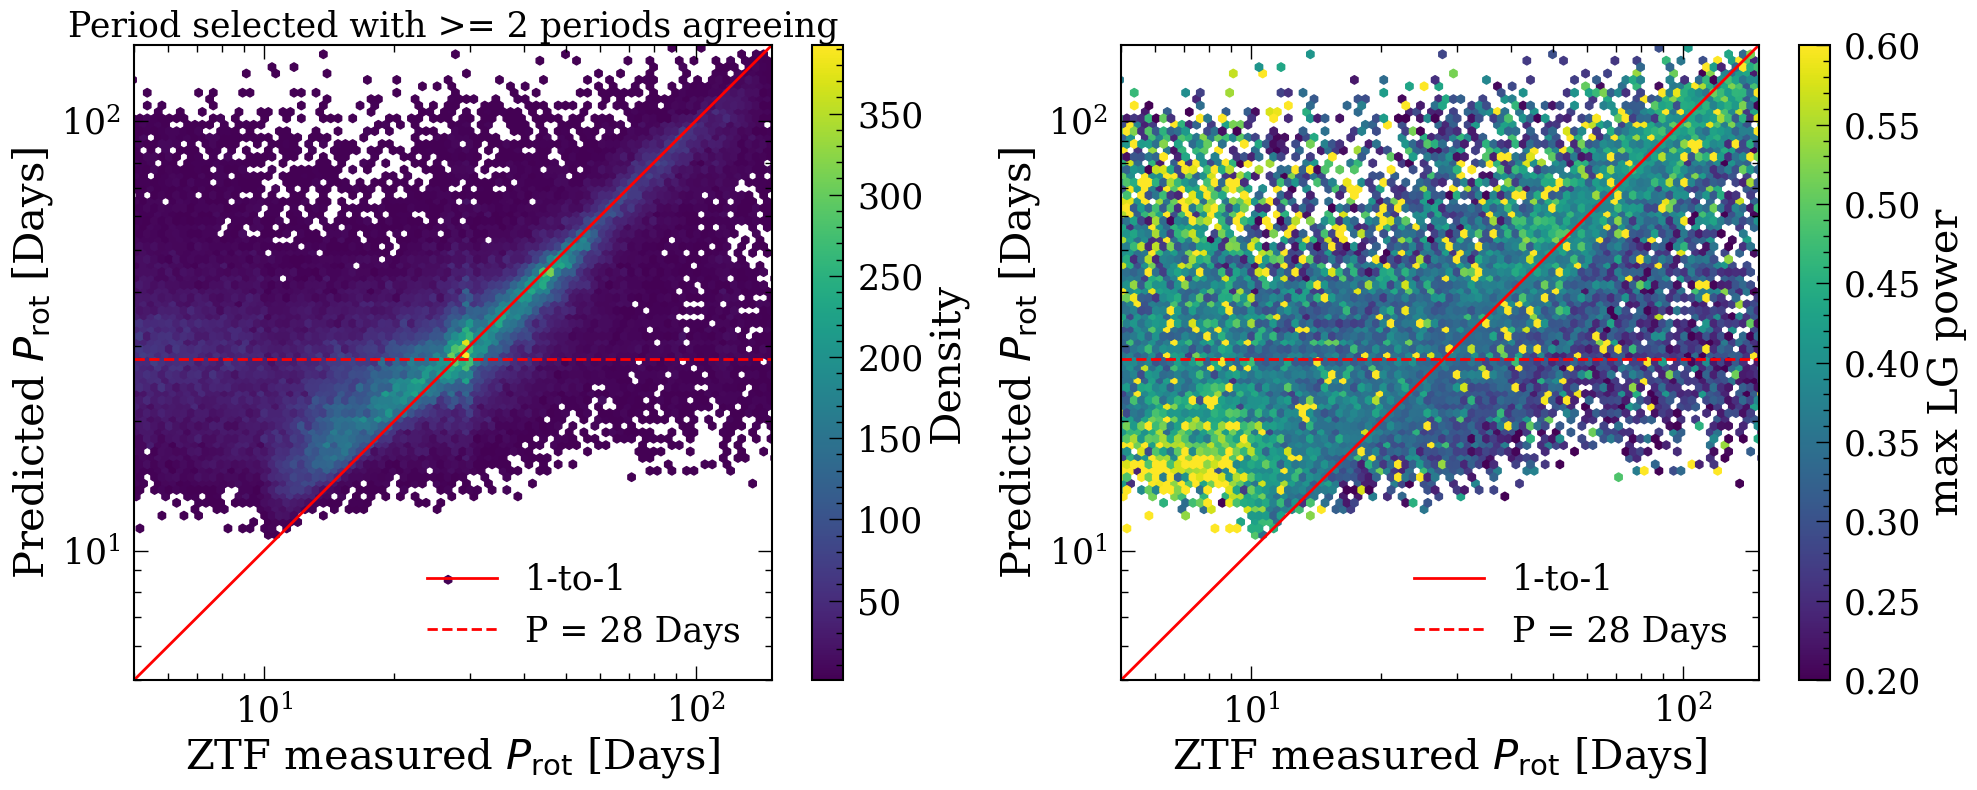

In [76]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(ztf_all['maxpowerprot'], ztf_all['Prot_pred'],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log')
plt.plot([1,200],[1,200], 'r-', label='1-to-1')
plt.xlabel('ZTF measured $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ [Days]')
plt.xlim([5,150])
plt.ylim([5,150])
plt.hlines(28, 5, 150, color='r', linestyle='--', label='P = 28 Days')
plt.colorbar(label='Density')
plt.legend(loc=4)
plt.title('Period selected with highest LG peak', fontsize=25)

plt.subplot(1,2,2)
plt.hexbin(ztf_all['maxpowerprot'], ztf_all['Prot_pred'],
           C=ztf_all['maxpowers'],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log', vmin=0.2, vmax=0.6)
plt.plot([1,200],[1,200], 'r-', label='1-to-1')
plt.xlabel('ZTF measured $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ [Days]')
plt.xlim([5,150])
plt.ylim([5,150])
plt.hlines(28, 5, 150, color='r', linestyle='--', label='P = 28 Days')
plt.colorbar(label='max LG power')
plt.legend(loc=4)
plt.tight_layout()


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(ztf_all['sameprot'], ztf_all['Prot_pred'],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log')
plt.plot([1,200],[1,200], 'r-', label='1-to-1')
plt.xlabel('ZTF measured $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ [Days]')
plt.xlim([5,150])
plt.ylim([5,150])
plt.hlines(28, 5, 150, color='r', linestyle='--', label='P = 28 Days')
plt.colorbar(label='Density')
plt.legend(loc=4)
plt.title('Period selected with >= 2 periods agreeing', fontsize=25)

plt.subplot(1,2,2)
plt.hexbin(ztf_all['sameprot'], ztf_all['Prot_pred'],
           C=ztf_all['maxpowers'],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log', vmin=0.2, vmax=0.6)
plt.plot([1,200],[1,200], 'r-', label='1-to-1')
plt.xlabel('ZTF measured $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ [Days]')
plt.xlim([5,150])
plt.ylim([5,150])
plt.hlines(28, 5, 150, color='r', linestyle='--', label='P = 28 Days')
plt.colorbar(label='max LG power')
plt.legend(loc=4)
plt.tight_layout()

/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_34545/3690791916.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_all_trust1['Prot'] = ztf_all['maxpowerprot']
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_34545/3690791916.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_all_trust2['Prot'] = ztf_all['sameprot']


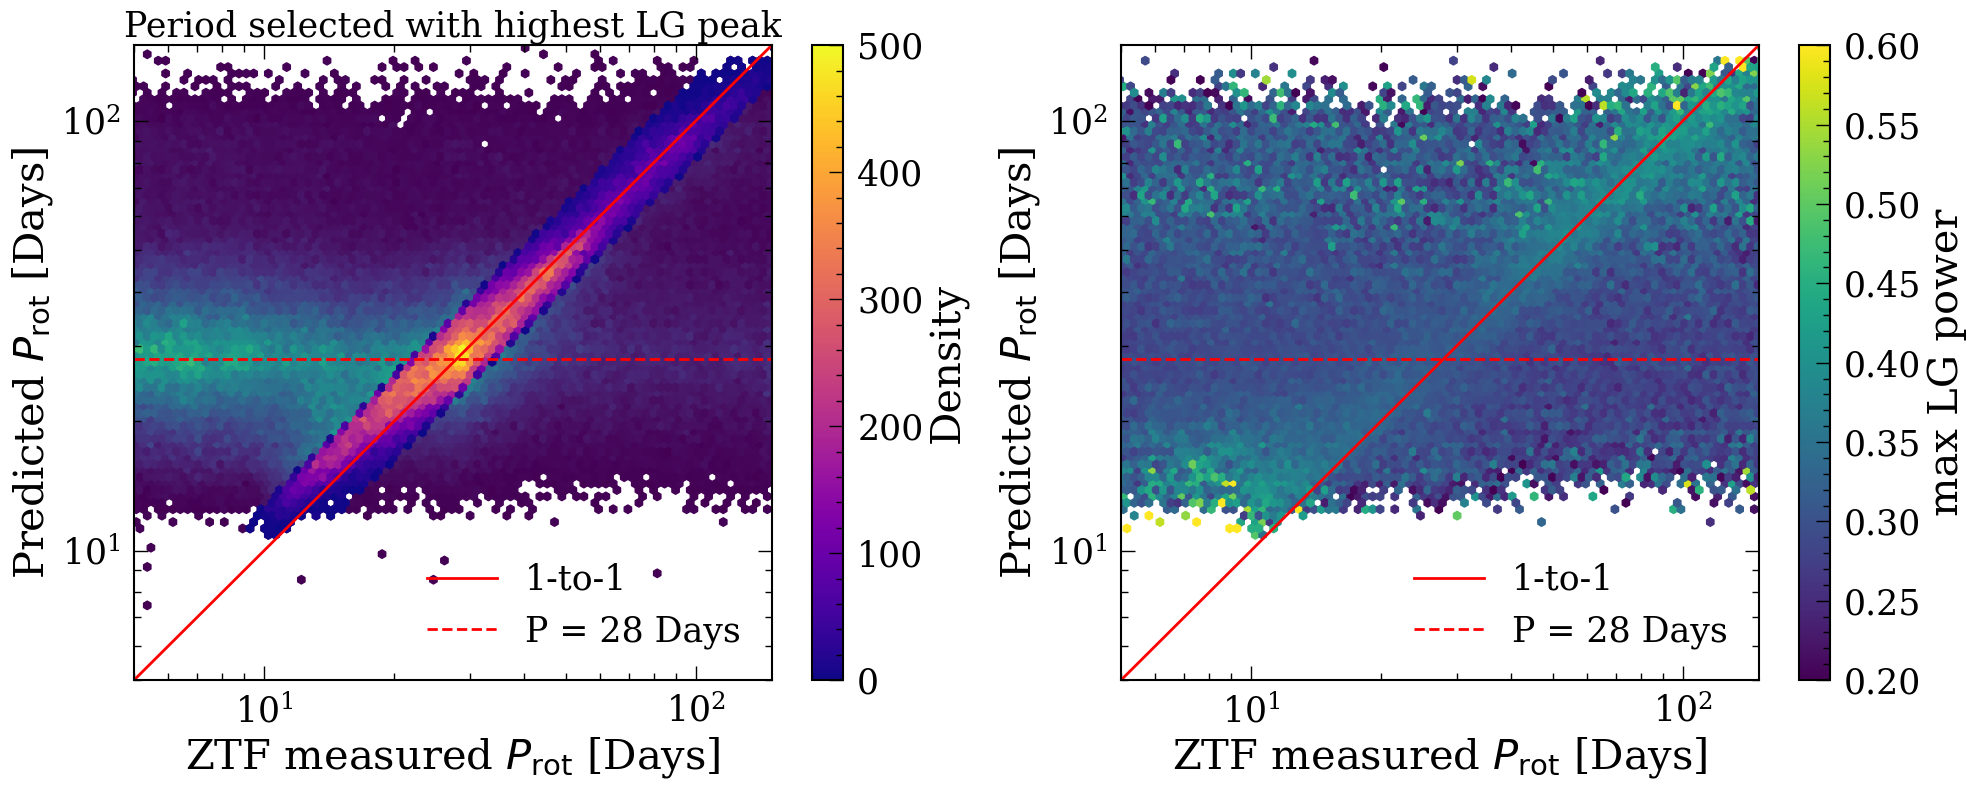

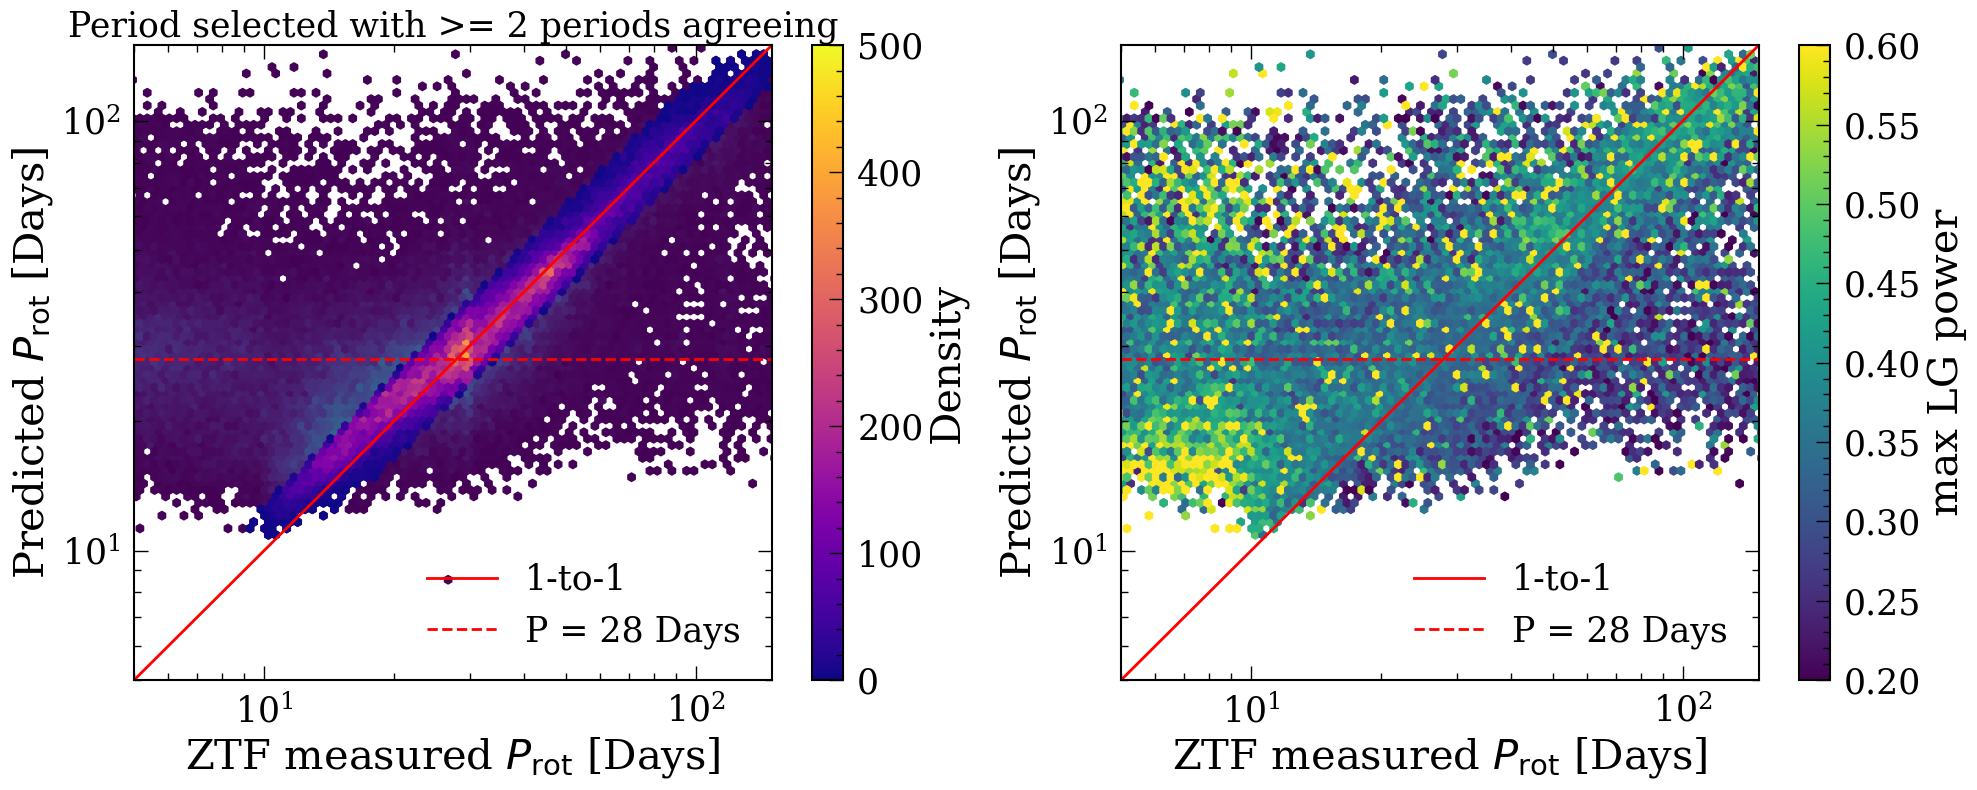

In [74]:
vetprot = abs(ztf_all['maxpowerprot']-ztf_all['Prot_pred'])/ztf_all['Prot_pred']<0.2

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(ztf_all['maxpowerprot'], ztf_all['Prot_pred'],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log', vmin=0, vmax=500)

plt.hexbin(ztf_all['maxpowerprot'][vetprot], ztf_all['Prot_pred'][vetprot],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log', cmap=plt.get_cmap('plasma'), 
           vmin=0, vmax=500)

plt.plot([1,200],[1,200], 'r-', label='1-to-1')
plt.xlabel('ZTF measured $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ [Days]')
plt.xlim([5,150])
plt.ylim([5,150])
plt.hlines(28, 5, 150, color='r', linestyle='--', label='P = 28 Days')
plt.colorbar(label='Density')
plt.legend(loc=4)
plt.title('Period selected with highest LG peak', fontsize=25)

plt.subplot(1,2,2)
plt.hexbin(ztf_all['maxpowerprot'], ztf_all['Prot_pred'],
           C=ztf_all['maxpowers'],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log', vmin=0.2, vmax=0.6)
plt.plot([1,200],[1,200], 'r-', label='1-to-1')
plt.xlabel('ZTF measured $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ [Days]')
plt.xlim([5,150])
plt.ylim([5,150])
plt.hlines(28, 5, 150, color='r', linestyle='--', label='P = 28 Days')
plt.colorbar(label='max LG power')
plt.legend(loc=4)
plt.tight_layout()

ztf_all_trust1 = ztf_all[vetprot]
ztf_all_trust1['Prot'] = ztf_all['maxpowerprot']







vetprot = abs(ztf_all['sameprot']-ztf_all['Prot_pred'])/ztf_all['Prot_pred']<0.2
ztf_all_trust2 = ztf_all[vetprot]
ztf_all_trust2['Prot'] = ztf_all['sameprot']


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(ztf_all['sameprot'], ztf_all['Prot_pred'],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log', vmin=0, vmax=500)
plt.hexbin(ztf_all['sameprot'][vetprot], ztf_all['Prot_pred'][vetprot],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log', cmap=plt.get_cmap('plasma'), 
           vmin=0, vmax=500)
plt.plot([1,200],[1,200], 'r-', label='1-to-1')
plt.xlabel('ZTF measured $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ [Days]')
plt.xlim([5,150])
plt.ylim([5,150])
plt.hlines(28, 5, 150, color='r', linestyle='--', label='P = 28 Days')
plt.colorbar(label='Density')
plt.legend(loc=4)
plt.title('Period selected with >= 2 periods agreeing', fontsize=25)

plt.subplot(1,2,2)
plt.hexbin(ztf_all['sameprot'], ztf_all['Prot_pred'],
           C=ztf_all['maxpowers'],
          mincnt=1, extent=(0.5,2.2,0.5,2.2), yscale='log',
          xscale='log', vmin=0.2, vmax=0.6)
plt.plot([1,200],[1,200], 'r-', label='1-to-1')
plt.xlabel('ZTF measured $P_{\\rm rot}$ [Days]')
plt.ylabel('Predicted $P_{\\rm rot}$ [Days]')
plt.xlim([5,150])
plt.ylim([5,150])
plt.hlines(28, 5, 150, color='r', linestyle='--', label='P = 28 Days')
plt.colorbar(label='max LG power')
plt.legend(loc=4)
plt.tight_layout()

In [152]:
ztf_all_trust = pd.concat([ztf_all_trust1, ztf_all_trust2])
ztf_all_trust = ztf_all_trust.drop_duplicates('gaiaid', keep='first')


In [103]:
#ztf_all_trust.to_csv('vettZTF.csv', index=False)
ztf_all_trust = pd.read_csv('vettZTF.csv')

In [153]:
len(ztf_all_trust)

58462

# Merge with the oringal sample

In [154]:
df_old = pd.read_csv('../StarAgeComp/allgyro_ztf_kepler_update.csv')
ztf_all_trust = pd.concat([ztf_all_trust, df_old.dropna(subset=['KIC'])])
ztf_all_trust_f = ztf_all_trust.drop_duplicates('source_id', keep='first')
ztf_all_trust_s = ztf_all_trust.drop_duplicates('source_id', keep='last')


Text(0, 0.5, 'ZTF measurement 2')

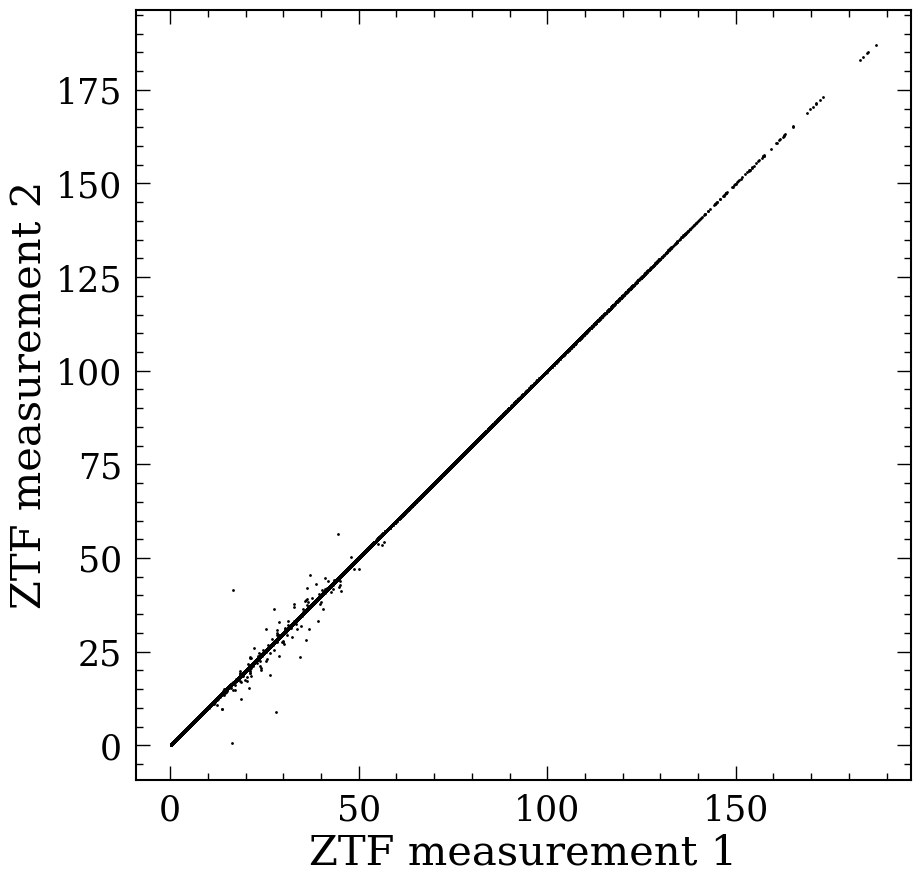

In [155]:
ztf_all_trust_both = pd.merge(ztf_all_trust_f[['source_id','Prot']], 
                              ztf_all_trust_s[['source_id','Prot']],
                              left_on='source_id',right_on='source_id',
                             how='inner')
plt.plot(ztf_all_trust_both['Prot_x'], ztf_all_trust_both['Prot_y'],
        'k.', markersize=2)
plt.xlabel('ZTF measurement 1')
plt.ylabel('ZTF measurement 2')
#plt.plot([0.1,200],[0.1,200],'r--')


In [159]:
ztf_all_trust = ztf_all_trust.drop_duplicates('source_id',keep='first')
len(ztf_all_trust)


111685

In [157]:
ztf_all_trust_kin = pd.merge(ztf_all_trust[['source_id','Prot']],
                            kinematic_dr3, left_on='source_id',
                            right_on='source_id', how='inner')
len(ztf_all_trust_kin)

74171

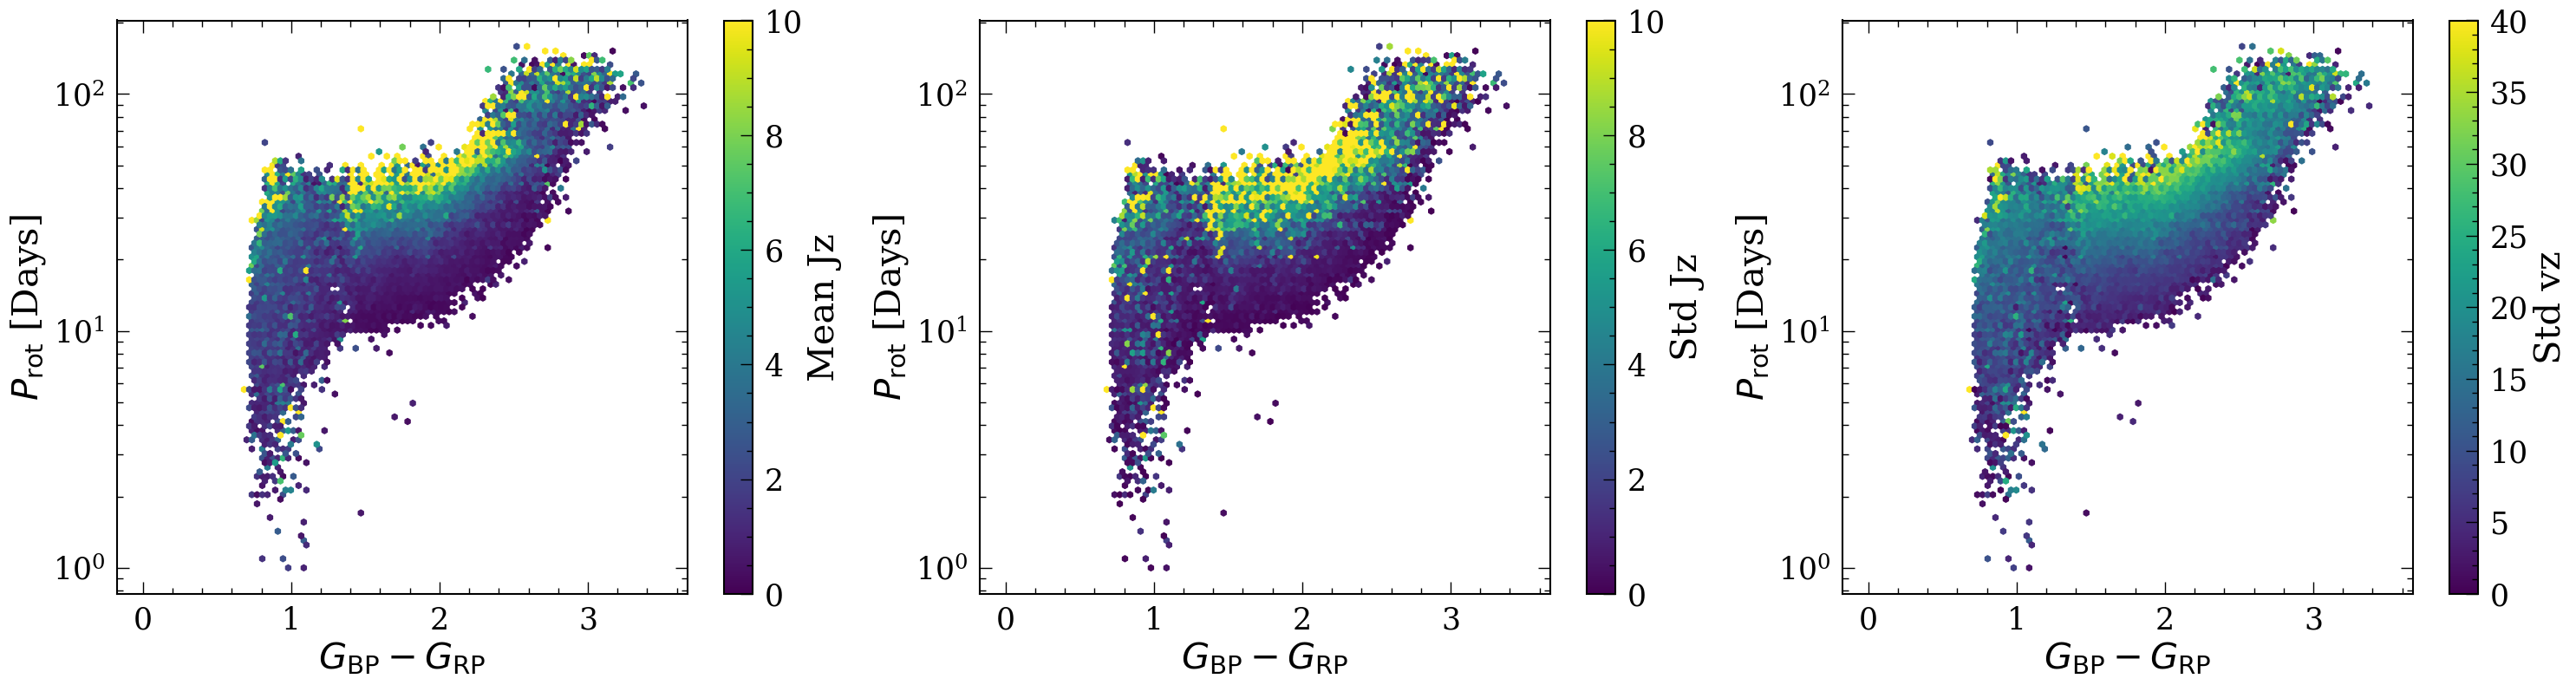

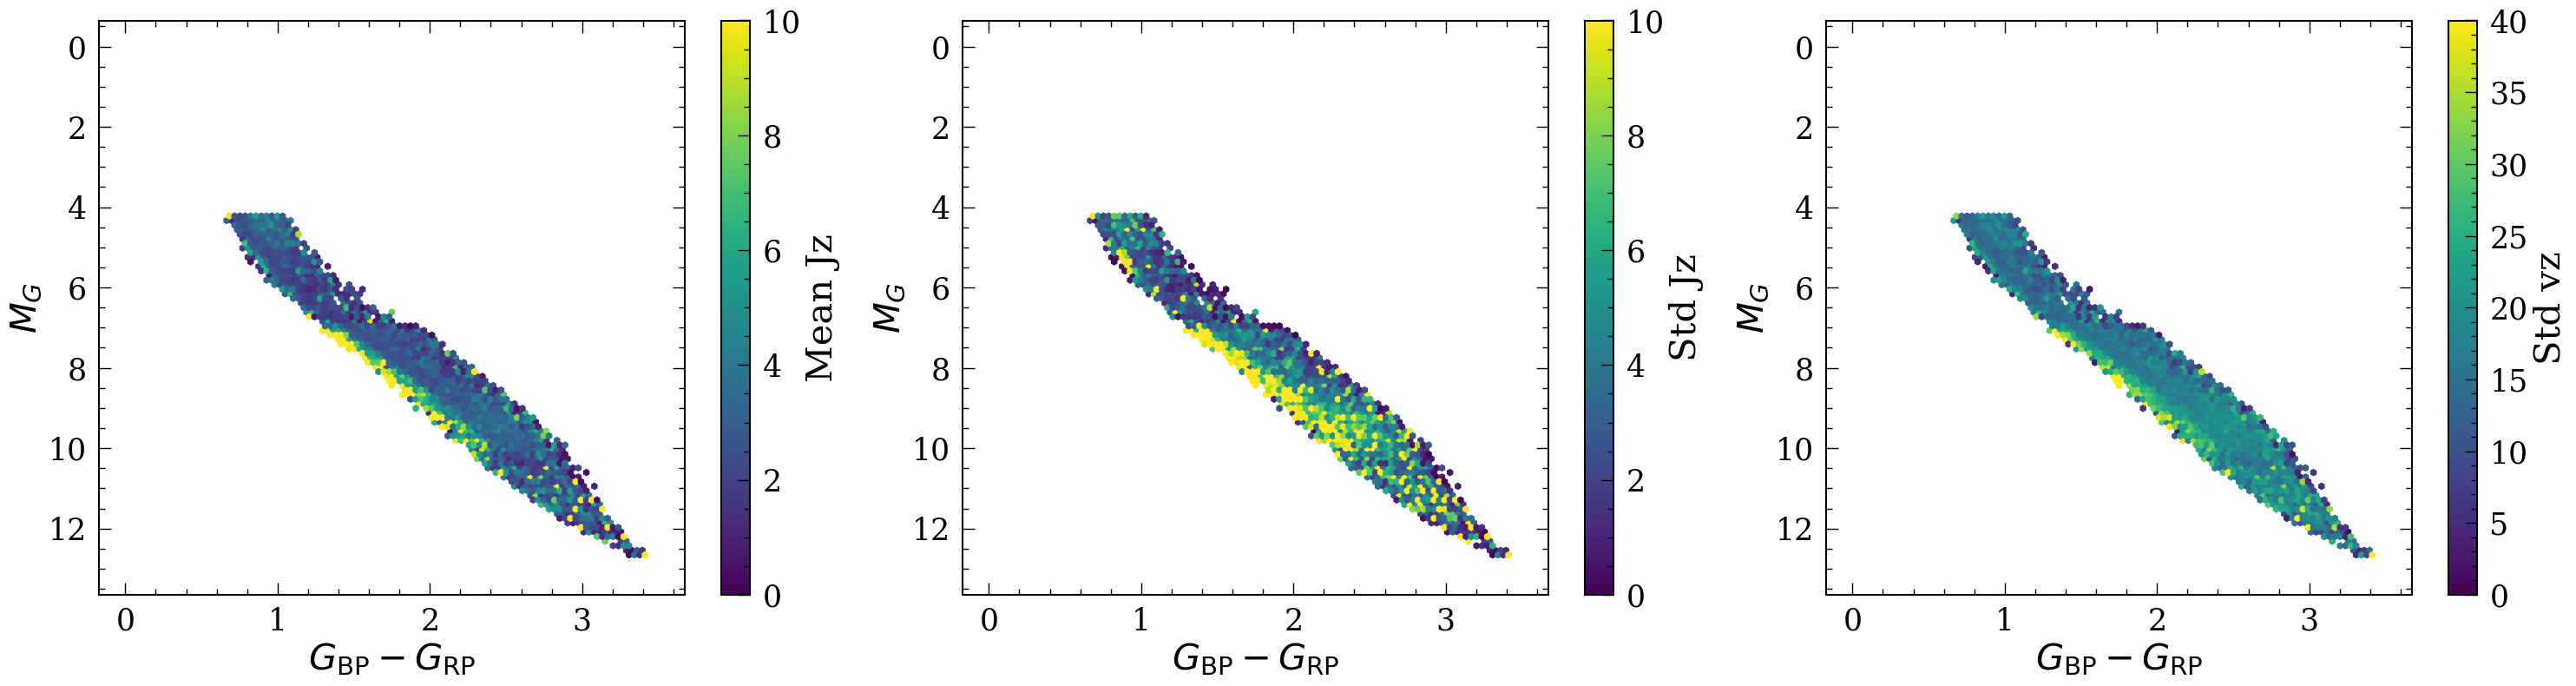

In [165]:
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(ztf_all_trust_kin['bp_rp'], ztf_all_trust_kin['Prot'],
           C=ztf_all_trust_kin['Jz'], extent=(0,3.5,0,2.2), 
           yscale='log', mincnt=1, vmin=0, vmax=10)
plt.colorbar(label='Mean Jz')
plt.xlabel('$G_{\\rm BP}-G_{\\rm RP}$')
plt.ylabel('$P_{\\rm rot}$ [Days]')


plt.subplot(1,3,2)
plt.hexbin(ztf_all_trust_kin['bp_rp'], ztf_all_trust_kin['Prot'],
           C=ztf_all_trust_kin['Jz'], extent=(0,3.5,0,2.2), 
           yscale='log', mincnt=1, vmin=0, vmax=10,
          reduce_C_function=np.std)
plt.colorbar(label='Std Jz')
plt.xlabel('$G_{\\rm BP}-G_{\\rm RP}$')
plt.ylabel('$P_{\\rm rot}$ [Days]')


plt.subplot(1,3,3)
plt.hexbin(ztf_all_trust_kin['bp_rp'], ztf_all_trust_kin['Prot'],
           C=ztf_all_trust_kin['vz'], extent=(0,3.5,0,2.2), 
           yscale='log', mincnt=1, vmin=0, vmax=40,
          reduce_C_function=np.std)
plt.colorbar(label='Std vz')
plt.xlabel('$G_{\\rm BP}-G_{\\rm RP}$')
plt.ylabel('$P_{\\rm rot}$ [Days]')
plt.tight_layout()


plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(ztf_all_trust_kin['bp_rp'], ztf_all_trust_kin['abs_G'],
           C=ztf_all_trust_kin['Jz'], extent=(0,3.5,0,13), 
            mincnt=1, vmin=0, vmax=10)
plt.colorbar(label='Mean Jz')
plt.xlabel('$G_{\\rm BP}-G_{\\rm RP}$')
plt.ylabel('$M_G$')
plt.gca().invert_yaxis()


plt.subplot(1,3,2)
plt.hexbin(ztf_all_trust_kin['bp_rp'], ztf_all_trust_kin['abs_G'],
           C=ztf_all_trust_kin['Jz'], extent=(0,3.5,0,13), 
            mincnt=1, vmin=0, vmax=10,
          reduce_C_function=np.std)
plt.colorbar(label='Std Jz')
plt.xlabel('$G_{\\rm BP}-G_{\\rm RP}$')
plt.ylabel('$M_G$')
plt.gca().invert_yaxis()


plt.subplot(1,3,3)
plt.hexbin(ztf_all_trust_kin['bp_rp'], ztf_all_trust_kin['abs_G'],
           C=ztf_all_trust_kin['vz'], extent=(0,3.5,0,13), 
            mincnt=1, vmin=0, vmax=40,
          reduce_C_function=np.std)
plt.colorbar(label='Std vz')
plt.xlabel('$G_{\\rm BP}-G_{\\rm RP}$')
plt.ylabel('$M_G$')
plt.gca().invert_yaxis()

plt.tight_layout()




In [193]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from itertools import product

mpf = '../NewGyroKineage/aviary/data/metal_poor_avr.csv'
mrf = '../NewGyroKineage/aviary/data/metal_rich_avr.csv'
af = '../NewGyroKineage/aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=15
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
            
            
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.std(iso_age_err_single)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,min_star=5,max_star=30,vz='v_b'):
    countsNo=0
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
        

    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_mr)

    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,min_star=5,max_star=30,sampsize=50,vz='v_b',vz_err='v_b_err'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        if 'Prot' in fs[i]:
            newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))
        else:
            newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new',min_star=min_star)
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df[np.append(['KID','kin_age_err'],fs)],df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df[np.append(['KID'],fs)],df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """    
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])

            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_mr)
        
        kinages = df_common['kin_age'].values
        m = (kinages!=kinages)
        kinages[m] = -999
        df_common['kin_age'] = kinages
        df_test = df_common
        
        
        if count==0:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            df_best=df_test
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:        
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                df_best=df_test
            count=count+1
        
    
    checkpara=np.zeros(fslen)
    
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])

        mask=np.ones(len(df), dtype=bool)
        """
        # subtract MS
        z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
           -3.54673368e-01,3.51882114e+02]
        p = np.poly1d(z)
        
        for i in range(len(fs)):
            if 'abs_G' in fs[i]:
                df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
                fs[i]='abs_G_sub'
        """    
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)

        vels_single=vels[mask]
        binfs_new=opt_binsize
            
            
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*1.1 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            #print(len(vels_single),binfs_new)
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_mr)
    kinages = df_common['kin_age'].values
    m = (kinages!=kinages)
    kinages[m] = -999
    df_common['kin_age'] = kinages
        
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]

    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq

    

        

def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        
    
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

def calc_tc(teff):
    return 314.24*np.exp(-(teff/1952.5)-(teff/6250)**18)+0.002

In [167]:
ztf_all_trust_kin['teff_calc'] = bprp_to_teff(ztf_all_trust_kin['bp_rp'])
df = ztf_all_trust_kin

In [168]:
df['τc'] = calc_tc(df['teff_calc'])
df['Ro'] = df['Prot']/df['τc']


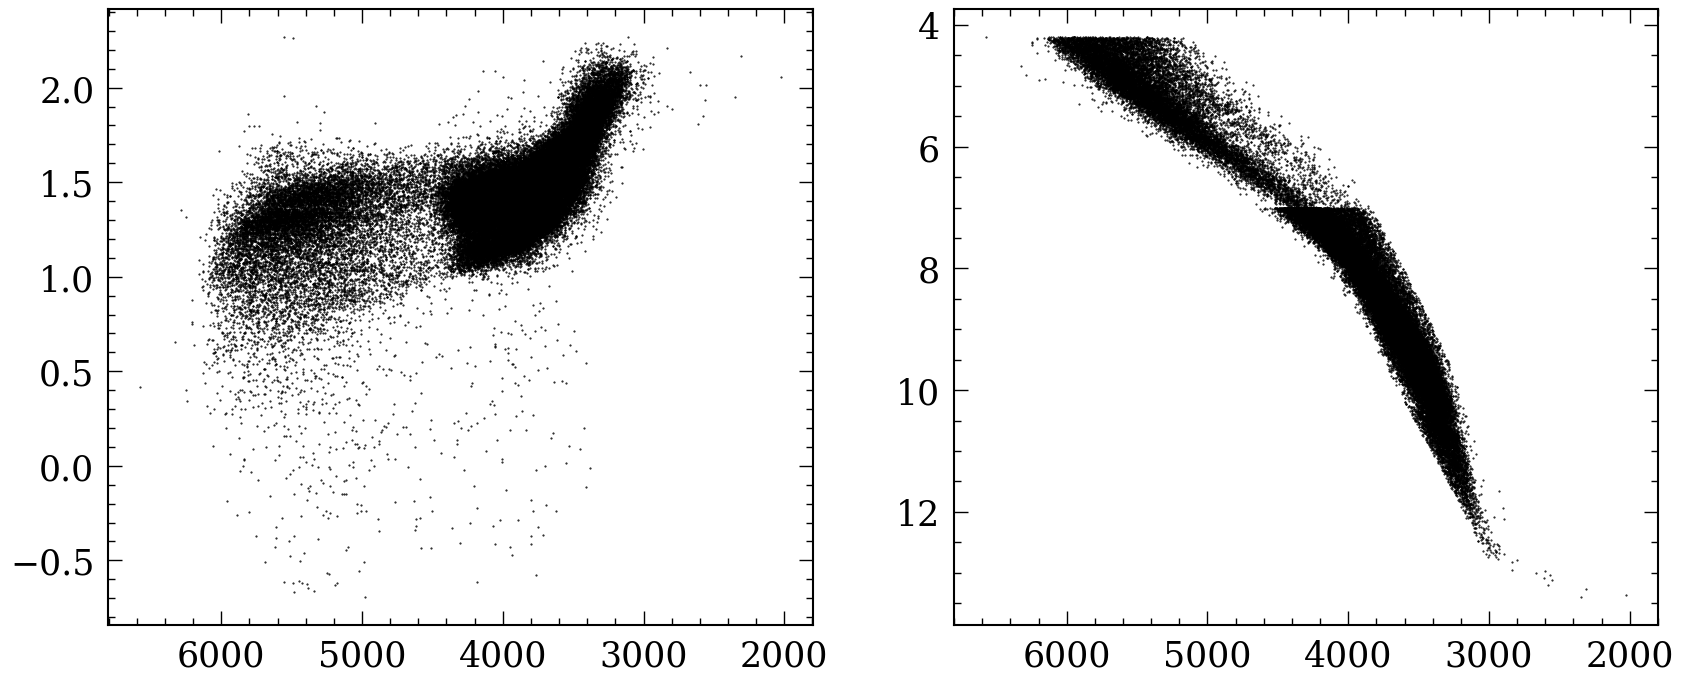

In [169]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df['teff_calc'], np.log10(df['Prot']), 'k.', markersize=1)
plt.gca().invert_xaxis()
plt.subplot(1,2,2)
plt.plot(df['teff_calc'], df['abs_G'], 'k.', markersize=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

67716


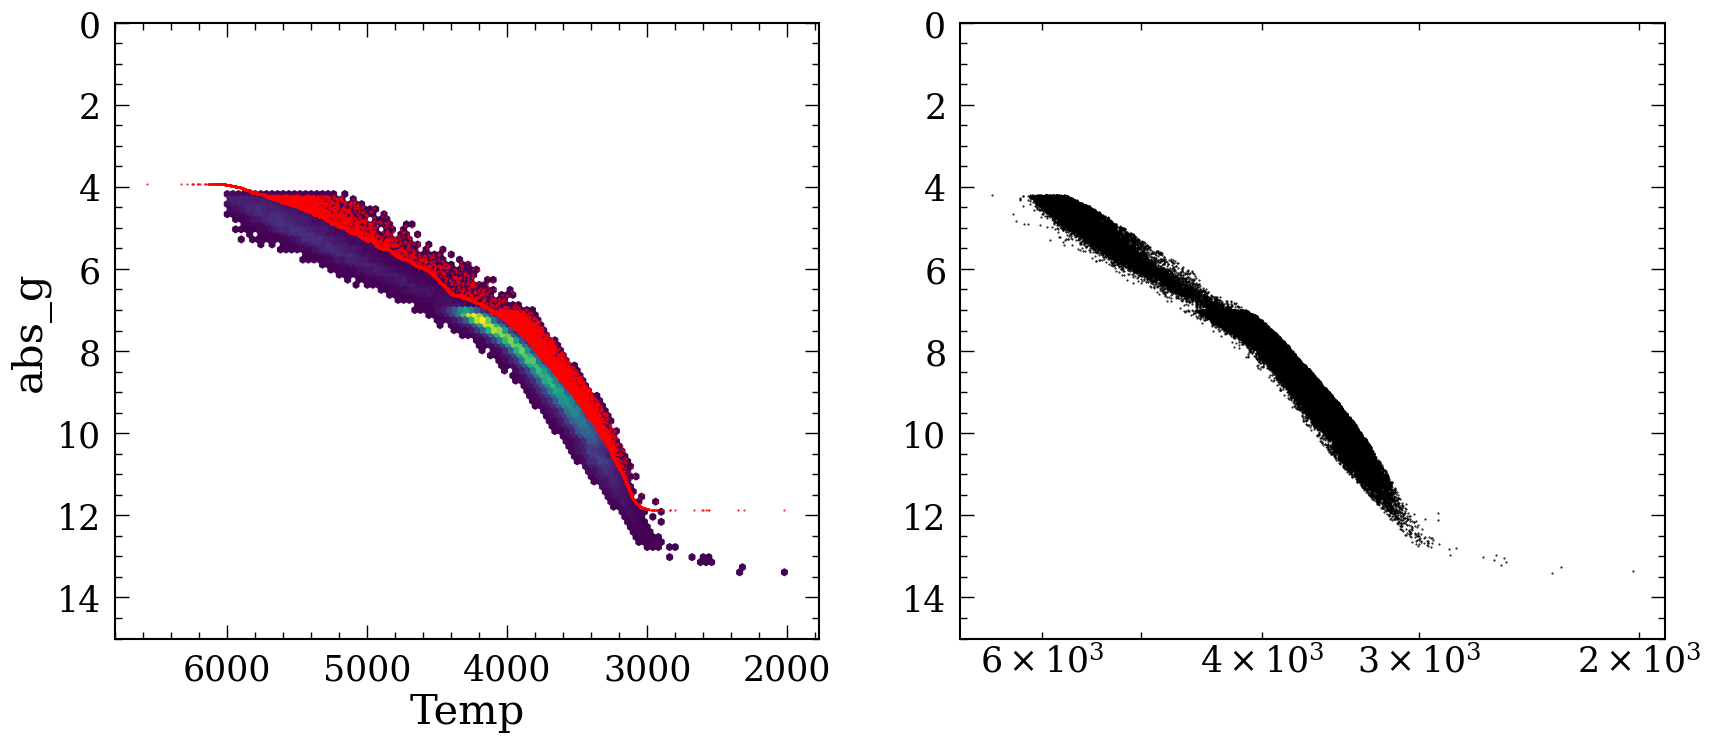

In [184]:
plt.figure(figsize=(20,8))


plt.subplot(1,2,1)
plt.hexbin(df['teff_calc'],df['abs_G'],
           extent=(2000,6000,0,14),mincnt=1)
df = df.sort_values(by='teff_calc').reset_index(drop=True)
absgsmooth = gaussian_filter(df['abs_G'].values, 100)

plt.plot(df['teff_calc'],absgsmooth-0.4,'r.',markersize=1)

m=df['abs_G']<absgsmooth-0.4
m=m&(df['abs_G']>4)

plt.plot(df['teff_calc'][m],df['abs_G'][m],'r.',markersize=1)
plt.ylim([0,15])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('abs_g')

plt.subplot(1,2,2)
df_nob = df[~m].reset_index(drop=True)
plt.semilogx(df_nob['teff_calc'],df_nob['abs_G'],'k.',markersize=1)
plt.ylim([0,15])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

print(len(df_nob))

In [187]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy


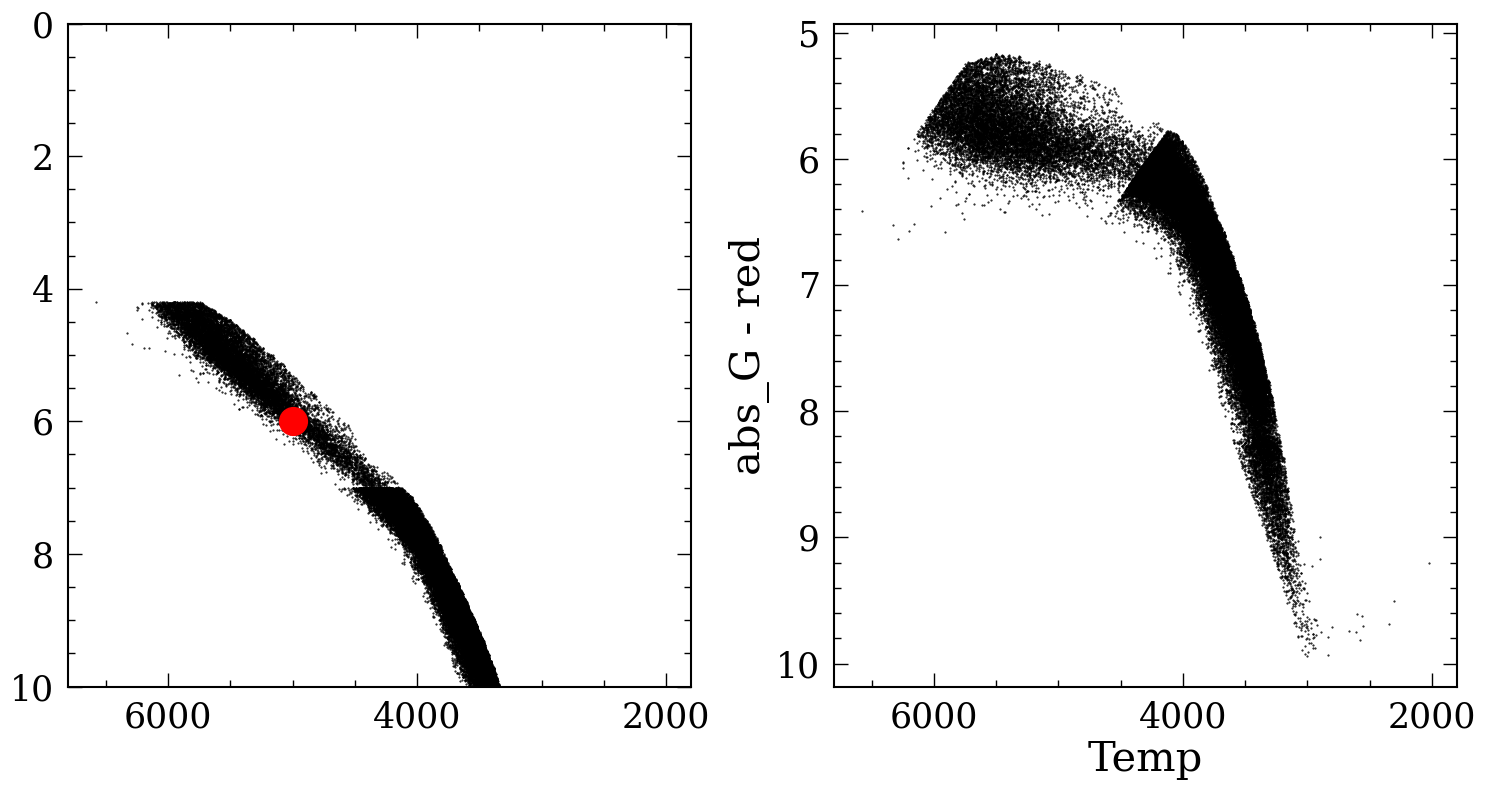

In [189]:
from scipy.ndimage import gaussian_filter
from scipy.spatial.transform import Rotation as R

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(df_nob['teff_calc'],df_nob['abs_G'],'k.',markersize=1)
#plt.plot(clusterAS['teff_calc'], clusterAS['abs_G'],'ro')

plt.plot([5e3],[6],'ro',markersize=20)

df_nob = df_nob.sort_values(by='teff_calc').reset_index(drop=True)

"""
r = R.from_euler('xyz',(80,80,0), degrees=True) 
p_r=r.apply(np.array([df_nob['teff_calc'].values,df_nob['abs_G'].values,
                      np.zeros(len(df_nob))]).T) #Rotated points
"""

df_nob['teff_rot'],df_nob['abs_G_rot'] = rotate([5e3,6],[df_nob['teff_calc'].values,df_nob['abs_G'].values],0.0014)

plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.plot(df_nob['teff_rot'],df_nob['abs_G_rot'],'k.',markersize=1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


plt.xlabel('Temp')
plt.ylabel('abs_G - red')
plt.tight_layout()

In [194]:
df_nob['Prot_log'] = np.log10(df_nob['Prot'])
df_nob['vel_dis'],df_nob['kin_age']=getkinAges(df_nob,['teff_calc','abs_G_rot','Ro','Prot_log'],
                                              [200.0, 0.01, 0.1711111111111111, 0.30000000000000004],
                                               vz='vz',min_star=15,
                                               max_star=50000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 67716/67716 [01:32<00:00, 732.64it/s]

24357



/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_34545/414172974.py:48: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_34545/414172974.py:48: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Text(0, 0.5, 'M$_G$')

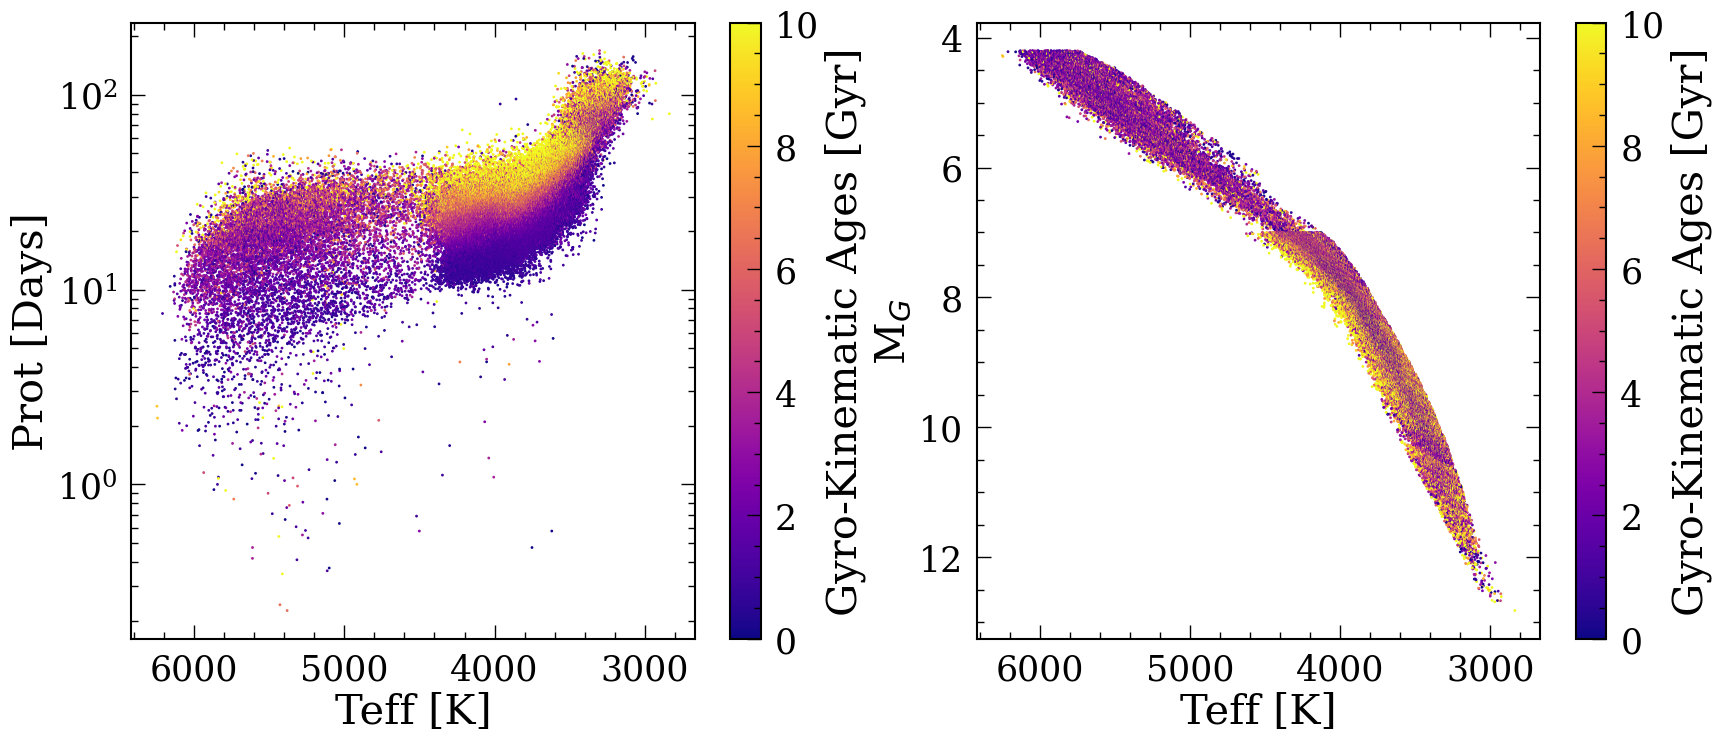

In [195]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],s=1,
            vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_xaxis()
plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')

plt.subplot(1,2,2)
plt.scatter(df_nob['teff_calc'], df_nob['abs_G'], c=df_nob['kin_age'],s=1,
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')





(10, 150)

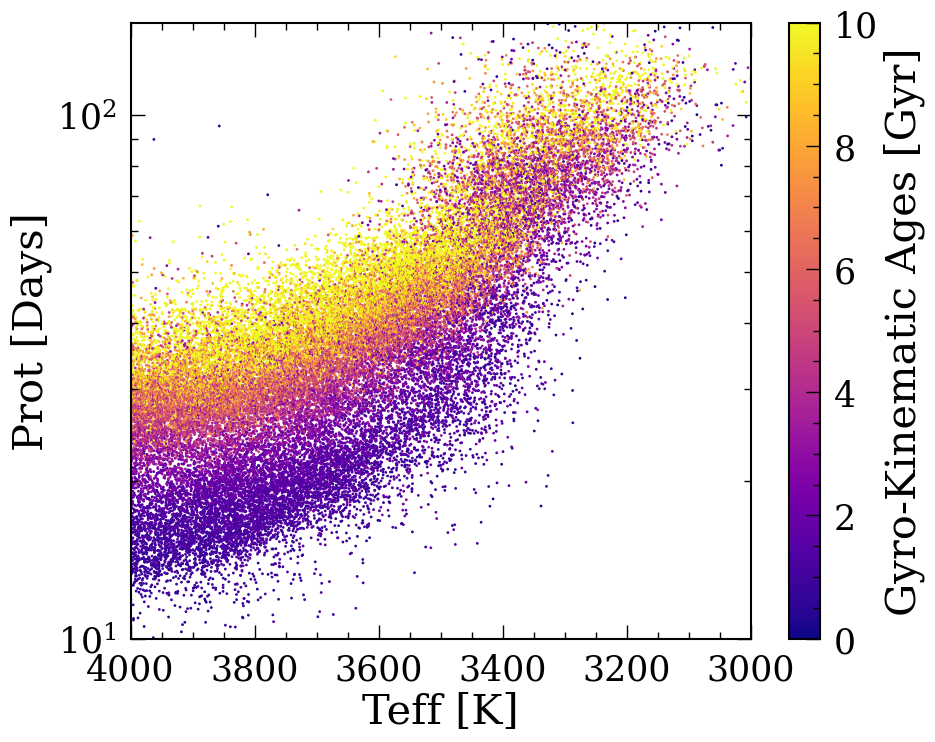

In [198]:
plt.figure(figsize=(10,8))
"""plt.hexbin(df_nob['teff_calc'], df_nob['Prot'], C=df_nob['kin_age'],
            vmin=0,vmax=10,cmap='plasma',extent=(3000,4500,np.log10(10),np.log10(150)),
           yscale='log',gridsize=50)"""

plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],
            vmin=0,vmax=10,cmap='plasma',s=1)
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
plt.yscale('log')
plt.xlim([4000,3000])
plt.ylim([10,150])
#plt.vlines(3450,ymax=150,ymin=10,color='r')
#plt.vlines(3400,ymax=150,ymin=10,color='r')




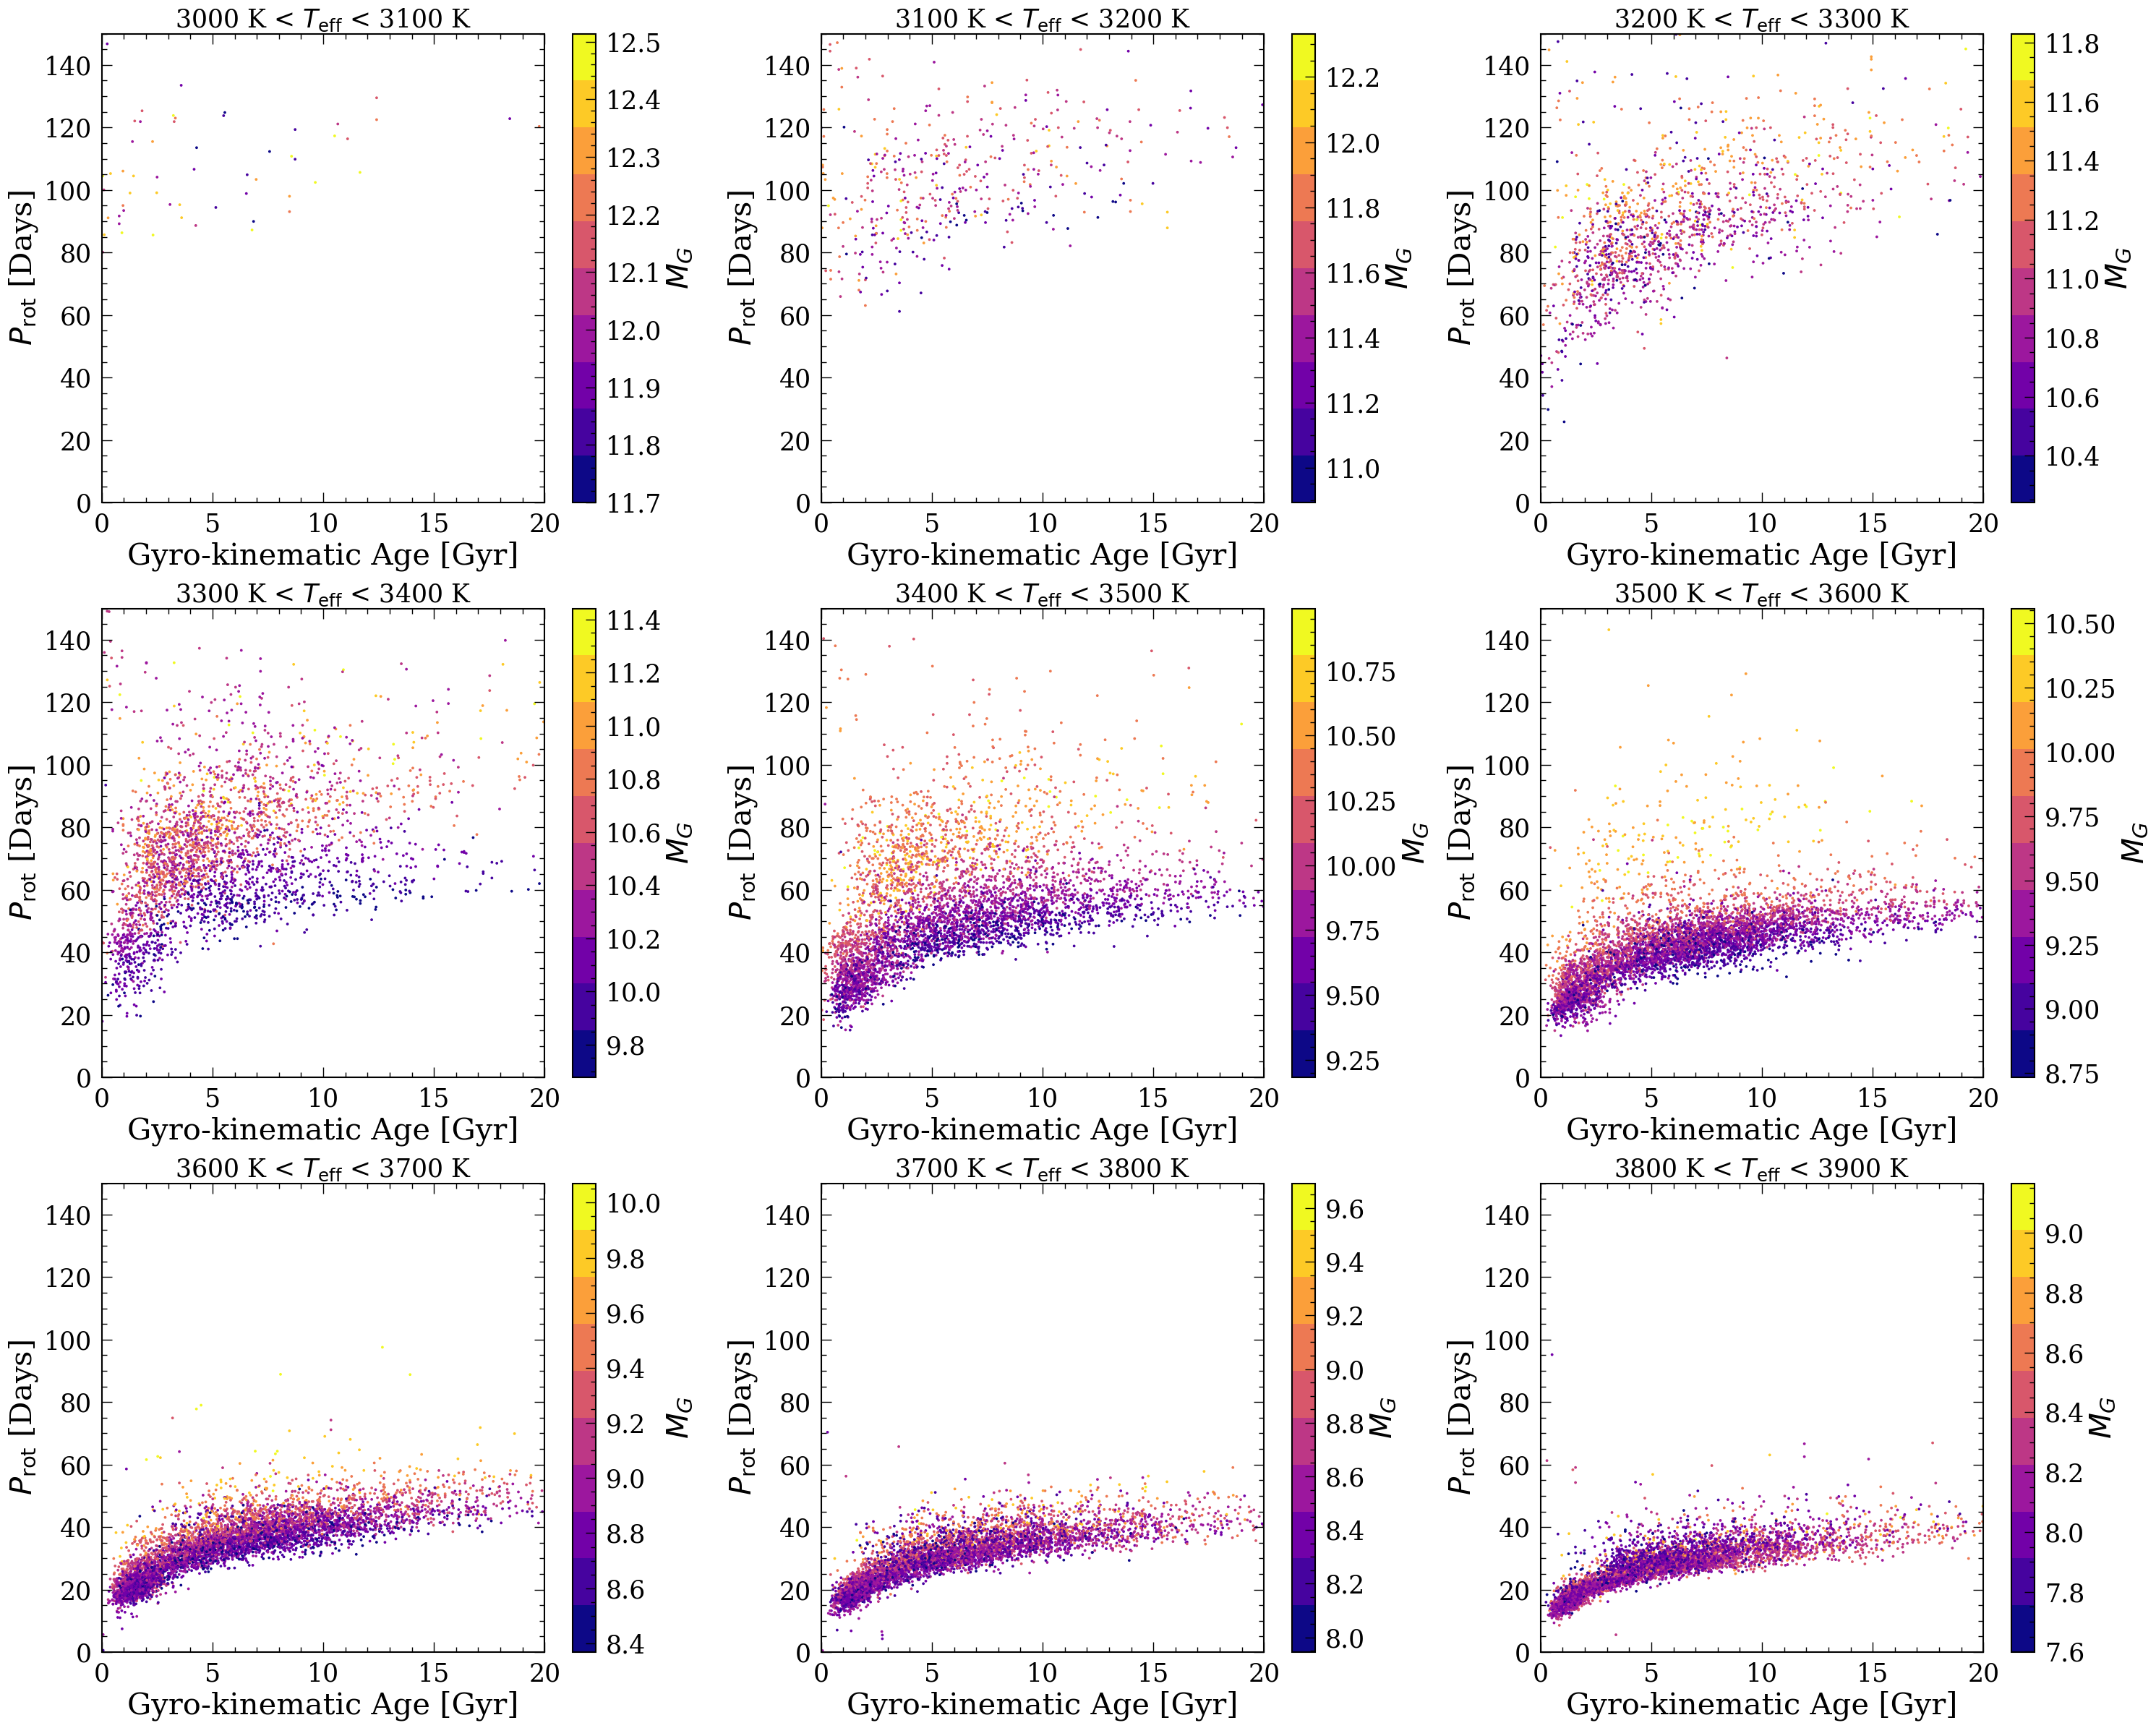

In [209]:
teffplot = np.linspace(3000,3900,10)
plt.figure(figsize=(30,24))
for i in range(len(teffplot)-1):
    df_nob_sing = df_nob.loc[(df_nob['teff_calc']>teffplot[i])&(df_nob['teff_calc']<teffplot[i+1])]
    plt.subplot(3,3,i+1)
    plt.scatter(df_nob_sing['kin_age'], df_nob_sing['Prot'], 
               c=df_nob_sing['abs_G'], s=3, 
                cmap=plt.get_cmap('plasma',10))
    plt.title('%d K < $T_{\\rm eff}$ < %d K'%(teffplot[i], teffplot[i+1]), fontsize=25)
    plt.xlabel('Gyro-kinematic Age [Gyr]')
    plt.ylabel('$P_{\\rm rot}$ [Days]')
    plt.xlim([0,20])
    plt.ylim([0,150])
    plt.colorbar(label='$M_G$')
plt.tight_layout()

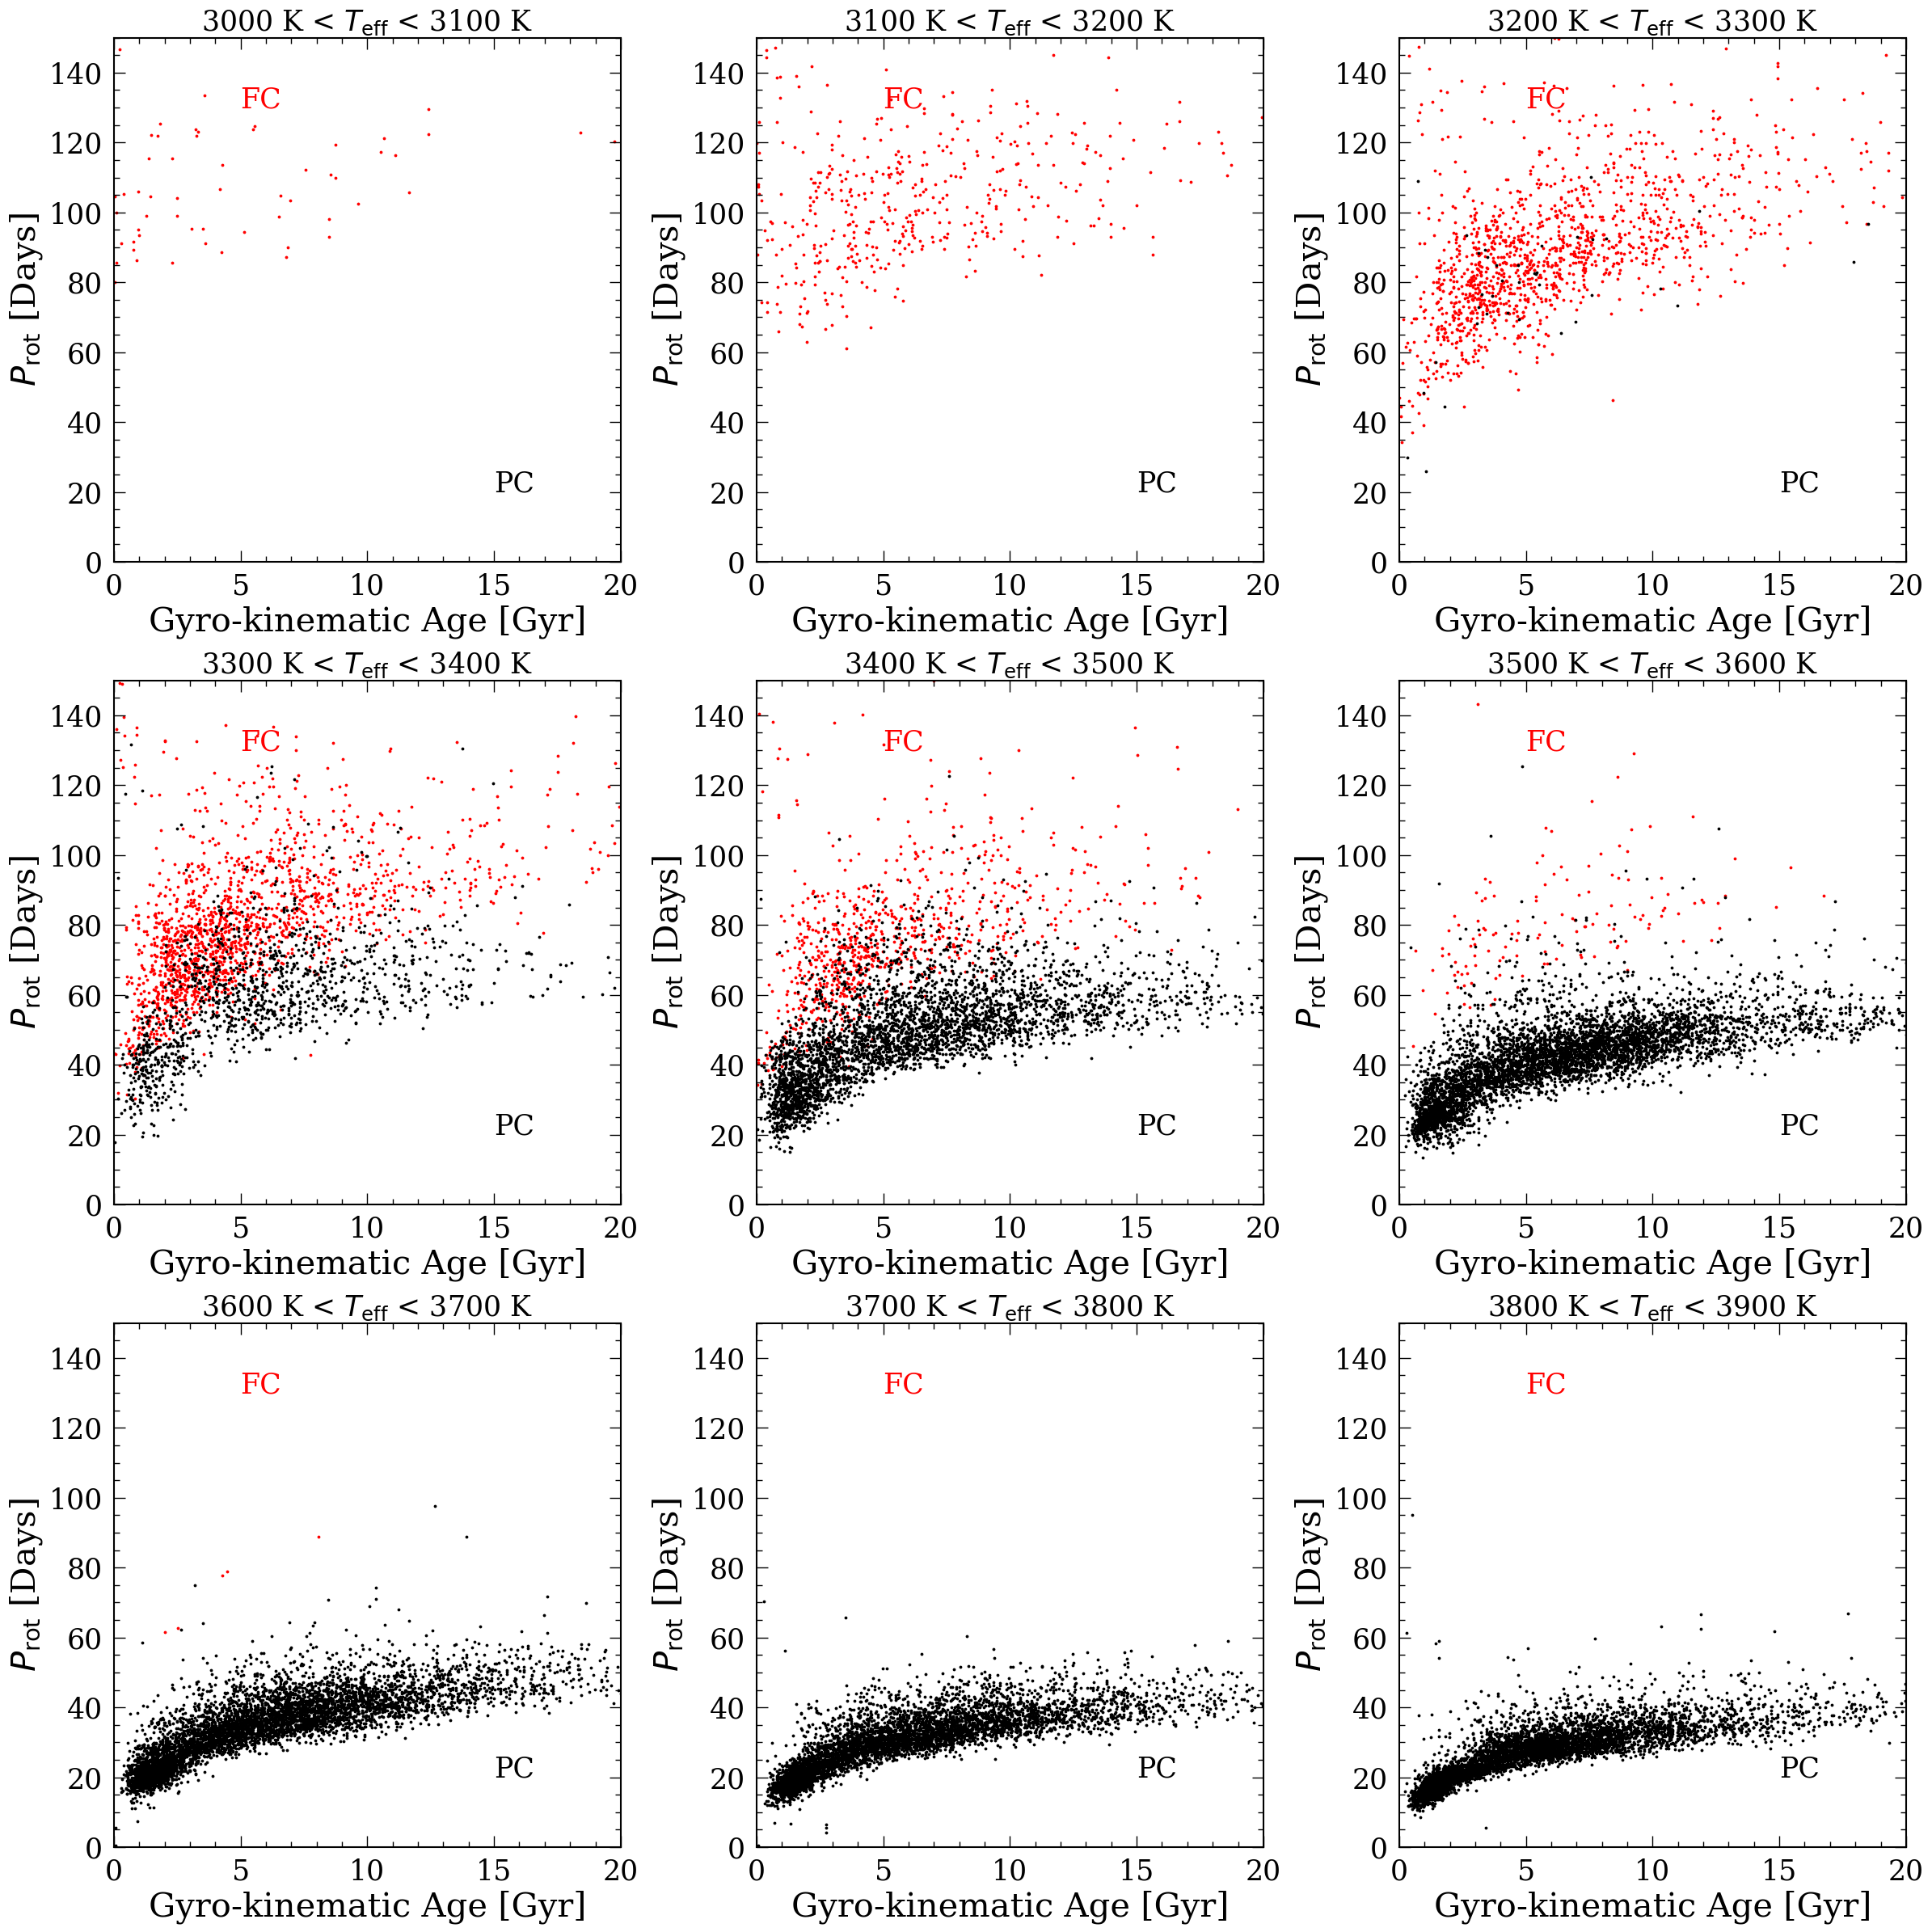

In [219]:
jaogap = fitpoints([3560/2+3526.5/2, 3427.36/2+3395.1/2], [10.09, 10.24])

plt.figure(figsize=(24,24))
for i in range(len(teffplot)-1):
    df_nob_sing = df_nob.loc[(df_nob['teff_calc']>teffplot[i])&(df_nob['teff_calc']<teffplot[i+1])]
    sing_obvJ = df_nob_sing.loc[df_nob_sing['abs_G']>jaogap(df_nob_sing['teff_calc'])]
    sing_belJ = df_nob_sing.loc[df_nob_sing['abs_G']<jaogap(df_nob_sing['teff_calc'])]


    plt.subplot(3,3,i+1)
    plt.scatter(sing_obvJ['kin_age'], sing_obvJ['Prot'], 
               color='r',s=3)
    plt.scatter(sing_belJ['kin_age'], sing_belJ['Prot'], 
               color='k',s=3)
    plt.title('%d K < $T_{\\rm eff}$ < %d K'%(teffplot[i], teffplot[i+1]), fontsize=25)
    plt.xlabel('Gyro-kinematic Age [Gyr]')
    plt.ylabel('$P_{\\rm rot}$ [Days]')
    plt.xlim([0,20])
    plt.ylim([0,150])
    plt.text(5,130,'FC',color='r',fontsize=25)
    plt.text(15,20,'PC',color='k',fontsize=25)
        
plt.tight_layout()
plt.savefig('NewSample.png')

In [221]:
#df_nob.to_csv('vettedAge.csv',index=False)